# AOL MACHINE LEARNING

Kelompok 6
1. Arieldhipta Tarliman - 2702234636
2. Nathan Otniel Halim Wirawan - 2702243054
3. Evorius Benedikt Suharta - 2702229112
4. Justin Hartanto Widjaja - 2702222610

# Stock Price Forecasting with SARIMAX and LSTM

The end goal of this project is to create an accurate/helpful tool to aid in trading stocks whether in a large scale or catered towards a certain individual/entities needs, there is a plethora of use cases in the real world of financial predictions as this model can be implemented in many areas/sectors and there is much room for integration and further improvement

# Dataset

https://www.kaggle.com/datasets/iveeaten3223times/massive-yahoo-finance-dataset/code?datasetId=4081618&sortBy=voteCount

This dataset contains historical daily stock market performances and prices from the top 500 companies by market cap collected by Yahoo Finances, each of the columns in the dataset is as follows:
- Date: Date when the stock data was collected
- Open: Opening price of a stock on a given date 
- High: Highest price of a stock on a given date 
- Low: Lowest price of a stock on a given date 
- Close: Closing price of a stock don a given date 
- Volume: Volume of shares traded in a day
- Dividends: Dividend payments made by the company on a given date 
- Stock Splits: Stock splits on a given date 
- Company: Identifier for a company

# Import Library

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import logging
logging.basicConfig(filename='warnings.log', level=logging.WARNING)
logging.captureWarnings(True)
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Set seed for ARIMAX
np.random.seed(42)
import random

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# set view rules
pd.set_option('display.max_rows', None)  # To show all rows
pd.set_option('display.max_columns', None)  # To show all columns
pd.set_option('display.width', None)  # To avoid truncation
pd.set_option('display.max_colwidth', None)  # To avoid truncation of long column contents

# Read Dataset

In [4]:
df = pd.read_csv("stock_details_5_years.csv")

# Selecting Company

To make things easier and more concise we decided to select the top 5 companies based on volume, reason we selected volume as our choice for selecting companies is a higher volume means a larger amount of trades/data is collected from that company overall, which should help lead to more accurate predictions and less anomalies / external factors that are out of control that might end up affecting our model

In [5]:
top_5_companies = df.groupby('Company')['Volume'].sum().nlargest(5).reset_index()
top_5_companies

Company        Volume
0    TSLA  168480836215
1    AAPL  130583503785
2    AMZN   97650968962
3     AMD   84350178302
4       F   81579990070

In [6]:
# Filter the dataset to include only the top 5 companies by volume
top_5_company_names = top_5_companies['Company']  # Extract the names of the top 5 companies
df = df[df['Company'].isin(top_5_company_names)]

df.head()
# Shows the first 5 rows which should show 5 different companies since the data is sorted by date

Date       Open       High        Low      Close  \
0    2018-11-29 00:00:00-05:00  43.829761  43.863354  42.639594  43.083508   
3    2018-11-29 00:00:00-05:00  83.749496  84.499496  82.616501  83.678497   
6    2018-11-29 00:00:00-05:00  23.133333  23.166668  22.636667  22.744667   
37   2018-11-29 00:00:00-05:00  21.190001  21.610001  20.730000  21.430000   
259  2018-11-29 00:00:00-05:00   7.533947   7.590230   7.445501   7.533947   

        Volume  Dividends  Stock Splits Company  
0    167080000        0.0           0.0    AAPL  
3    132264000        0.0           0.0    AMZN  
6     46210500        0.0           0.0    TSLA  
37    79853700        0.0           0.0     AMD  
259   29207600        0.0           0.0       F

# Simple Data Exploration

In [7]:
df.head()

Date       Open       High        Low      Close  \
0    2018-11-29 00:00:00-05:00  43.829761  43.863354  42.639594  43.083508   
3    2018-11-29 00:00:00-05:00  83.749496  84.499496  82.616501  83.678497   
6    2018-11-29 00:00:00-05:00  23.133333  23.166668  22.636667  22.744667   
37   2018-11-29 00:00:00-05:00  21.190001  21.610001  20.730000  21.430000   
259  2018-11-29 00:00:00-05:00   7.533947   7.590230   7.445501   7.533947   

        Volume  Dividends  Stock Splits Company  
0    167080000        0.0           0.0    AAPL  
3    132264000        0.0           0.0    AMZN  
6     46210500        0.0           0.0    TSLA  
37    79853700        0.0           0.0     AMD  
259   29207600        0.0           0.0       F

Displays the first 5 rows

In [8]:
df.describe()

Open         High          Low        Close        Volume  \
count  6290.000000  6290.000000  6290.000000  6290.000000  6.290000e+03   
mean     99.786038   101.475388    98.024026    99.791194  8.945079e+07   
std      78.144131    79.650885    76.497349    78.092477  5.814801e+07   
min       3.723498     3.854301     3.453174     3.496775  1.188160e+07   
25%      23.734666    24.255000    23.389501    23.871668  5.381682e+07   
50%      92.050003    93.405012    90.779499    92.161499  7.421540e+07   
75%     149.449069   151.832466   147.012301   149.569416  1.055882e+08   
max     411.470001   414.496674   405.666656   409.970001  9.140820e+08   

         Dividends  Stock Splits  
count  6290.000000   6290.000000  
mean      0.001096      0.005087  
std       0.016989      0.267446  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       0.800000     20.000000

Our numerical descriptions of our dataframe, we can see that our Open, High, Low, and Close columns have pretty similar values which could make them redundant. 

Dividends and stock splits also seem to have alot of 0 values which will end up causing problems for our model by not providing much information

# Handling Columns

## Check Data Type

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6290 entries, 0 to 602737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6290 non-null   object 
 1   Open          6290 non-null   float64
 2   High          6290 non-null   float64
 3   Low           6290 non-null   float64
 4   Close         6290 non-null   float64
 5   Volume        6290 non-null   int64  
 6   Dividends     6290 non-null   float64
 7   Stock Splits  6290 non-null   float64
 8   Company       6290 non-null   object 
dtypes: float64(6), int64(1), object(2)
memory usage: 491.4+ KB


All of our columns have the correct data type already

## Add New Column

To extract more data we decided to split our Date column into Year, Month, Day, DayOfWeek, Quarter, and ElapsedDays(How many days since the 1st Jan of the first year in our data). We hope to extract seasonal data and trends from this

In [10]:
# Step 1: Convert `Date` to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

# Step 2: Extract features
if df['Date'].dtype == 'datetime64[ns, UTC]':  # Ensure datetime dtype
    df['Year'] = df['Date'].dt.year.astype('int64')       # Extract year
    df['Month'] = df['Date'].dt.month.astype('int64')     # Extract month
    df['Day'] = df['Date'].dt.day.astype('int64')         # Extract day
    df['DayOfWeek'] = df['Date'].dt.dayofweek.astype('int64')  # Extract day of the week (0=Monday, 6=Sunday)
    df['Quarter'] = df['Date'].dt.quarter.astype('int64')  # Extract quarter (1, 2, 3, or 4)
    # Calculate the elapsed days since a baseline date
    df['ElapsedDays'] = (df['Date'] - pd.Timestamp("2018-01-01", tz='UTC')).dt.days
    df['Date'] = df['Date'].dt.date
else:
    print("Error: `Date` column is not datetime-like")


In [11]:
df.head()

Date       Open       High        Low      Close     Volume  \
0    2018-11-29  43.829761  43.863354  42.639594  43.083508  167080000   
3    2018-11-29  83.749496  84.499496  82.616501  83.678497  132264000   
6    2018-11-29  23.133333  23.166668  22.636667  22.744667   46210500   
37   2018-11-29  21.190001  21.610001  20.730000  21.430000   79853700   
259  2018-11-29   7.533947   7.590230   7.445501   7.533947   29207600   

     Dividends  Stock Splits Company  Year  Month  Day  DayOfWeek  Quarter  \
0          0.0           0.0    AAPL  2018     11   29          3        4   
3          0.0           0.0    AMZN  2018     11   29          3        4   
6          0.0           0.0    TSLA  2018     11   29          3        4   
37         0.0           0.0     AMD  2018     11   29          3        4   
259        0.0           0.0       F  2018     11   29          3        4   

     ElapsedDays  
0            332  
3            332  
6            332  
37           332  
259          332

Our updated dataframe with new columns

# Handling Unique Value

In [12]:
def show_unique_values(df, max_display=32):
    for column in df.columns:
        unique_values = df[column].unique()
        unique_count = len(unique_values)
        print(f"Column '{column}' has {unique_count} unique values.")
        
        # Display only the first 'max_display' unique values
        if unique_count > max_display:
            print(f"Sample unique values: {unique_values[:max_display]} ...")
        else:
            print(f"Unique values: {unique_values}")
        print("-" * 50)

# Call the function
show_unique_values(df)

Column 'Date' has 1258 unique values.
Sample unique values: [datetime.date(2018, 11, 29) datetime.date(2018, 11, 30)
 datetime.date(2018, 12, 3) datetime.date(2018, 12, 4)
 datetime.date(2018, 12, 6) datetime.date(2018, 12, 7)
 datetime.date(2018, 12, 10) datetime.date(2018, 12, 11)
 datetime.date(2018, 12, 12) datetime.date(2018, 12, 13)
 datetime.date(2018, 12, 14) datetime.date(2018, 12, 17)
 datetime.date(2018, 12, 18) datetime.date(2018, 12, 19)
 datetime.date(2018, 12, 20) datetime.date(2018, 12, 21)
 datetime.date(2018, 12, 24) datetime.date(2018, 12, 26)
 datetime.date(2018, 12, 27) datetime.date(2018, 12, 28)
 datetime.date(2018, 12, 31) datetime.date(2019, 1, 2)
 datetime.date(2019, 1, 3) datetime.date(2019, 1, 4)
 datetime.date(2019, 1, 7) datetime.date(2019, 1, 8)
 datetime.date(2019, 1, 9) datetime.date(2019, 1, 10)
 datetime.date(2019, 1, 11) datetime.date(2019, 1, 14)
 datetime.date(2019, 1, 15) datetime.date(2019, 1, 16)] ...
--------------------------------------------

# Handling Duplicated Values

## Check Duplicated Values

In [13]:
df[df.duplicated()]

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Company, Year, Month, Day, DayOfWeek, Quarter, ElapsedDays]
Index: []

There are no duplicated values

# Handling Missing Values

## Check Missing Values

In [14]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Company, Year, Month, Day, DayOfWeek, Quarter, ElapsedDays]
Index: []

There are no missing values

# Summary

In [15]:
missing_values = df.isnull().mean()*100
data_type = df.dtypes
unique_values_count = df.nunique()
null_count = df.isnull().sum()

summary_1 = pd.DataFrame({
    'Null Count': null_count,
    'Null %': missing_values,
    'Datatype': data_type,
    'Unique value': unique_values_count
})

summary_1.sort_values(by = 'Null %', ascending= False)

Null Count  Null % Datatype  Unique value
Date                   0     0.0   object          1258
Open                   0     0.0  float64          6079
High                   0     0.0  float64          6062
Low                    0     0.0  float64          6089
Close                  0     0.0  float64          5910
Volume                 0     0.0    int64          6260
Dividends              0     0.0  float64            10
Stock Splits           0     0.0  float64             5
Company                0     0.0   object             5
Year                   0     0.0    int64             6
Month                  0     0.0    int64            12
Day                    0     0.0    int64            31
DayOfWeek              0     0.0    int64             5
Quarter                0     0.0    int64             4
ElapsedDays            0     0.0    int64          1258

This is as expected from our dataframe we can see that there is 1258 days of data collected spanning over 6 years, Why is there 6 years but only 1258 days? We can see from our day of week column that the stock market is open for 5 days a week

# Plotting

## Stock Closing Prices

Here we will be displaying/visualizing stock closing prices overtime to evaluate how each of our select companies perform

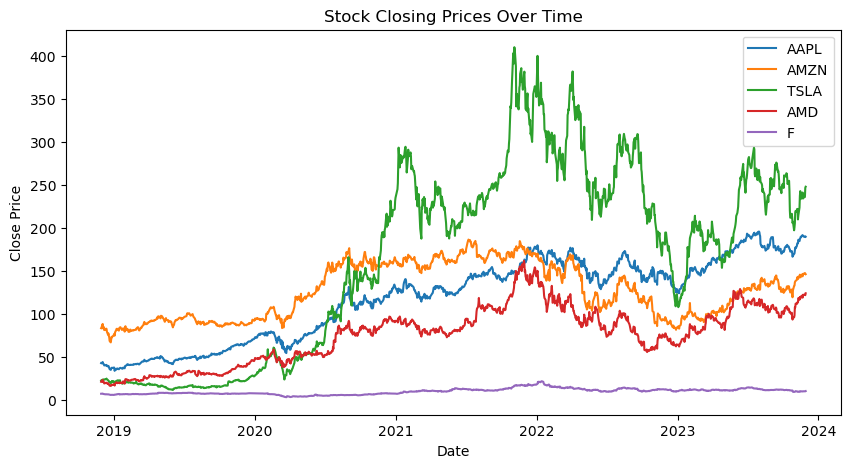

In [16]:
plt.figure(figsize=(10, 5))

for company in df['Company'].unique():
    subset = df[df['Company'] == company]
    plt.plot(subset['Date'], subset['Close'], label=company)

plt.title("Stock Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In our first plot we plot the prices for all our selected companies for the whole span of our data

From here we can conclude a few things such as 
- Ford (F) stock prices are the most stable in comparison to the others
- The other stocks have a much higher average yet a higher deviation as well
- Our most volitile stock is TSLA reaching the highest highs and lowest lows (outside of Ford)

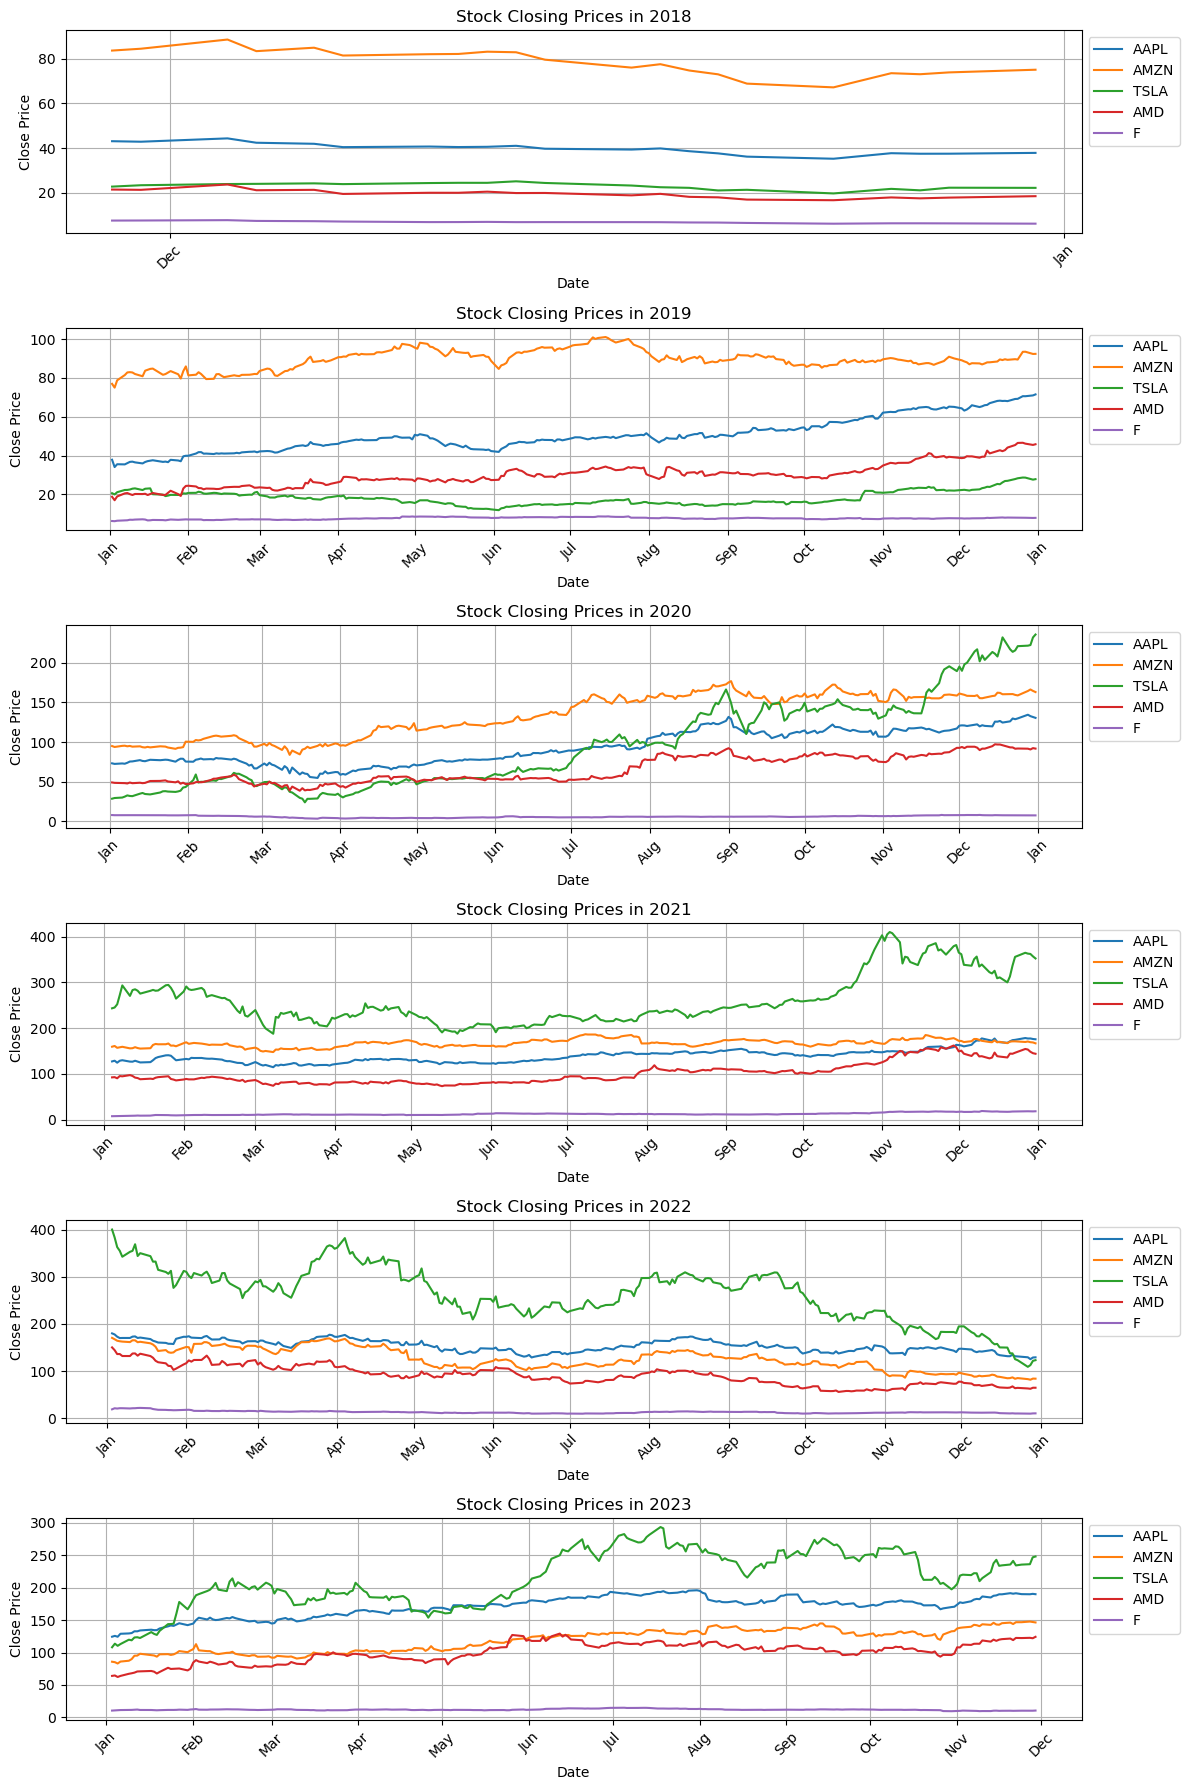

In [17]:
years = df['Year'].unique()

# Set up the plot grid: len(years) rows and 1 column (vertically stacked plots)
plt.figure(figsize=(12, len(years) * 3))

# Loop through each year and create a subplot for each year
for i, year in enumerate(years, 1):
    plt.subplot(len(years), 1, i)  # Create a subplot for each year
    year_subset = df[df['Year'] == year]
    
    # Loop through each company and plot its closing prices for the current year
    for company in year_subset['Company'].unique():
        company_subset = year_subset[year_subset['Company'] == company]
        plt.plot(company_subset['Date'], company_subset['Close'], label=company)
    
    # Set titles and labels
    plt.title(f"Stock Closing Prices in {year}")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    
    # Set the x-axis to show months (instead of individual dates)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Place tick every month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Show month abbreviation
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add legend and grid for better visibility
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

These plots are sectioned off per year instead of the whole timeframe our dataframe was collected. We can see here the statement I made before stands somewhat true as we can see TSLA stock prices surging above the rest in a few years and reaching a really low point in another, We can also see that AMD,AMZN,APPL generally follow the same pattern/range so we can expect them to perform similarly in our model. As for FORD it doesn't have much deviation so I expect it to perform the best in evaluation metrics / actual predicting.

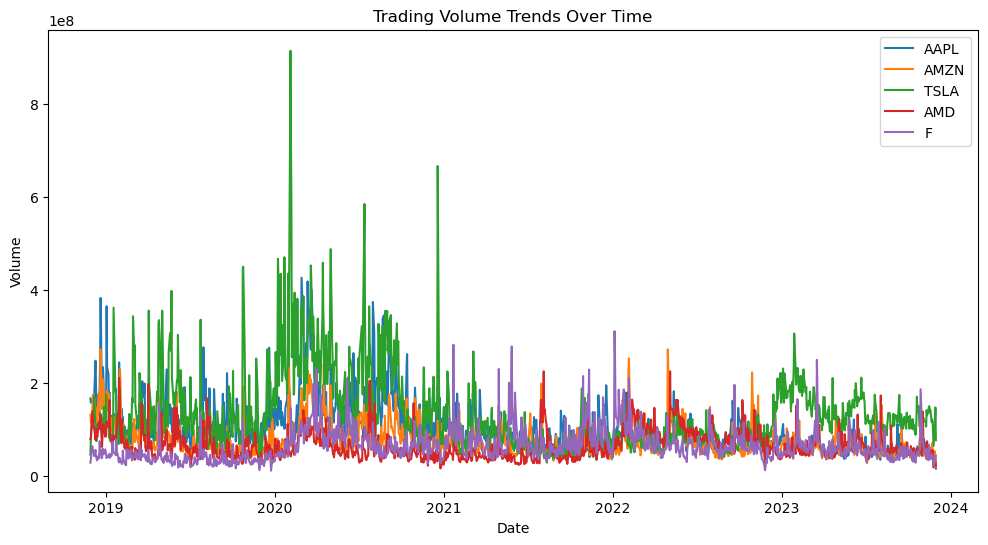

In [18]:
# Plot volume trends for each company
plt.figure(figsize=(12, 6))
for company in df['Company'].unique():
    subset = df[df['Company'] == company]
    plt.plot(subset['Date'], subset['Volume'], label=company)

plt.title("Trading Volume Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()



This plot shows us the volume of trades that happen within each company for the period when the data was collected, we can see that TSLA stands out having the highest highs and high fluctuations in comparison to the others.

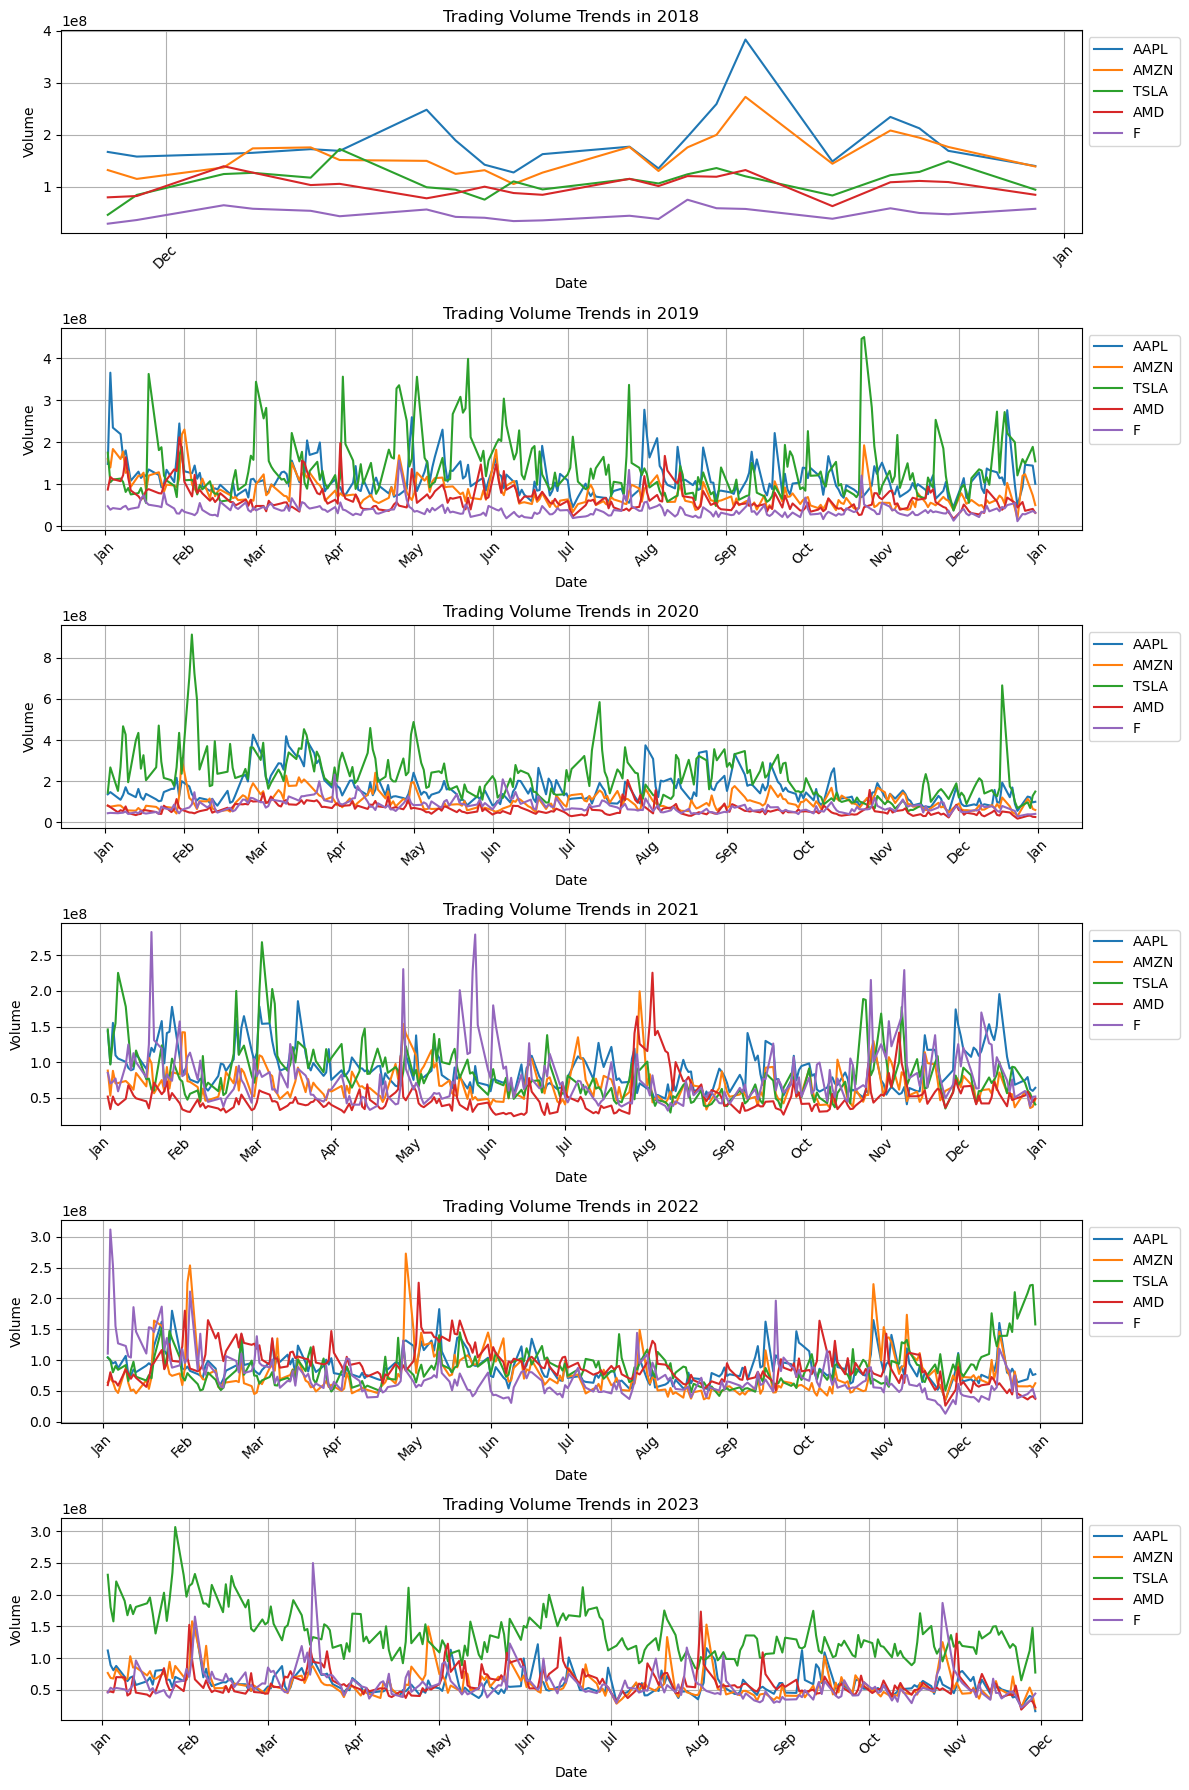

In [19]:

# Get the list of unique years in the dataset
years = df['Year'].unique()

# Set up the plot grid: len(years) rows and 1 column (vertically stacked plots)
plt.figure(figsize=(12, len(years) * 3))

# Loop through each year and create a subplot for each year
for i, year in enumerate(years, 1):
    plt.subplot(len(years), 1, i)  # Create a subplot for each year
    year_subset = df[df['Year'] == year]
    
    # Loop through each company and plot its trading volume for the current year
    for company in year_subset['Company'].unique():
        company_subset = year_subset[year_subset['Company'] == company]
        plt.plot(company_subset['Date'], company_subset['Volume'], label=company)
    
    # Set titles and labels
    plt.title(f"Trading Volume Trends in {year}")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    
    # Set the x-axis to show months (instead of individual dates)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Place tick every month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Show month abbreviation
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add legend and grid for better visibility
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

In the volume trend plots seperated by each year we can see the progress of a few company and trends such as in 2019 we see that AAPL is the highest growing company, and by 2020 TSLA has grown to see a high fluctuation of trade volumes

In [20]:
# List of numerical columns to plot
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'ElapsedDays']
# List of categorical columns to plot
categorical_columns = ['Company', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']
# List of exeption columns to plot
exeption_columns = ['Stock Splits','Dividends']

## Distribution for Numerical Features

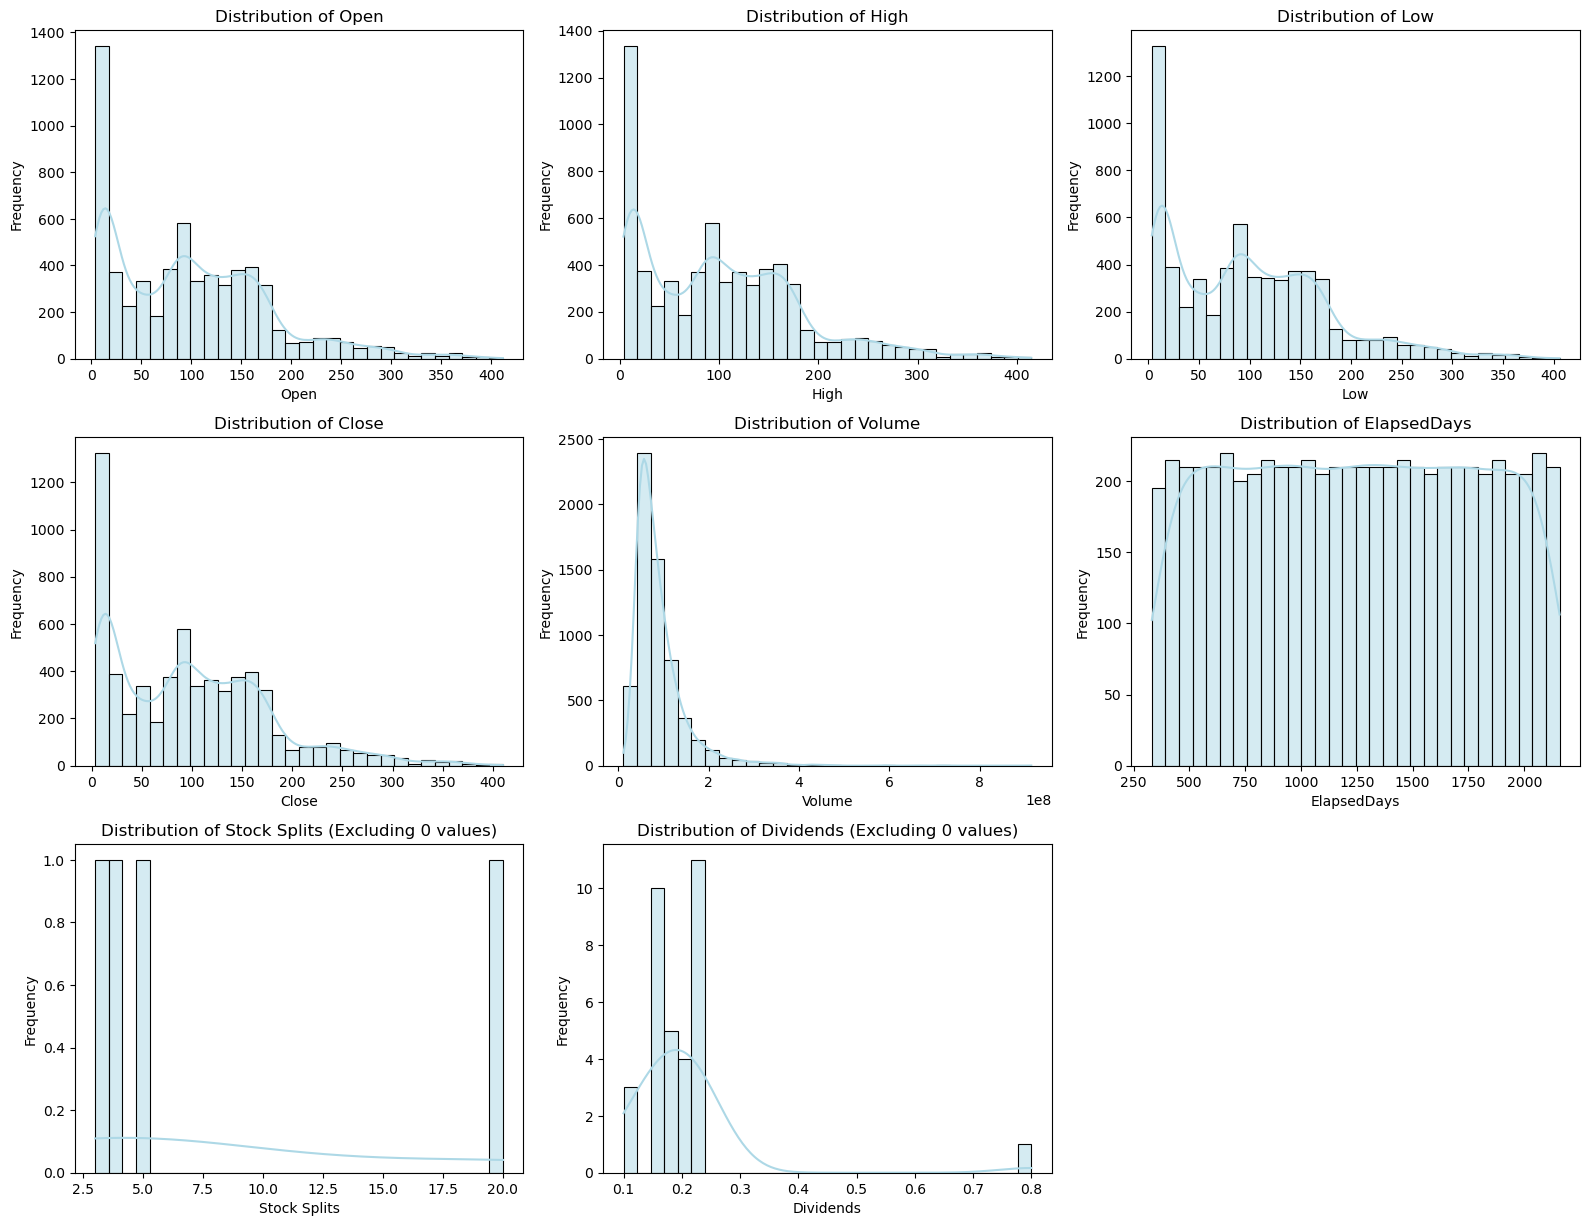

In [21]:
# Set up the plot grid: Adjust the number of rows and columns
plt.figure(figsize=(16, 16))

# Plotting the numerical features (histogram + KDE for regular columns)
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 3, i)  # Adjust the number of columns to 3 for numerical data
    sns.histplot(df[col], kde=True, color='lightblue', bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Plotting the exception columns (Stock Splits and Dividends, excluding 0 values)
for i, col in enumerate(exeption_columns, len(numerical_columns) + 1):
    plt.subplot(4, 3, i)  # Continue plotting in the next rows
    filtered_data = df[df[col] > 0]  # Filter out 0 values
    sns.histplot(filtered_data[col], kde=True, color='lightblue', bins=30)
    plt.title(f'Distribution of {col} (Excluding 0 values)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Adjust layout for better spacing and readability
plt.tight_layout()

# Show the plots
plt.show()

The plots above dont really give much information except the correlation between Open, High, Low and Close.

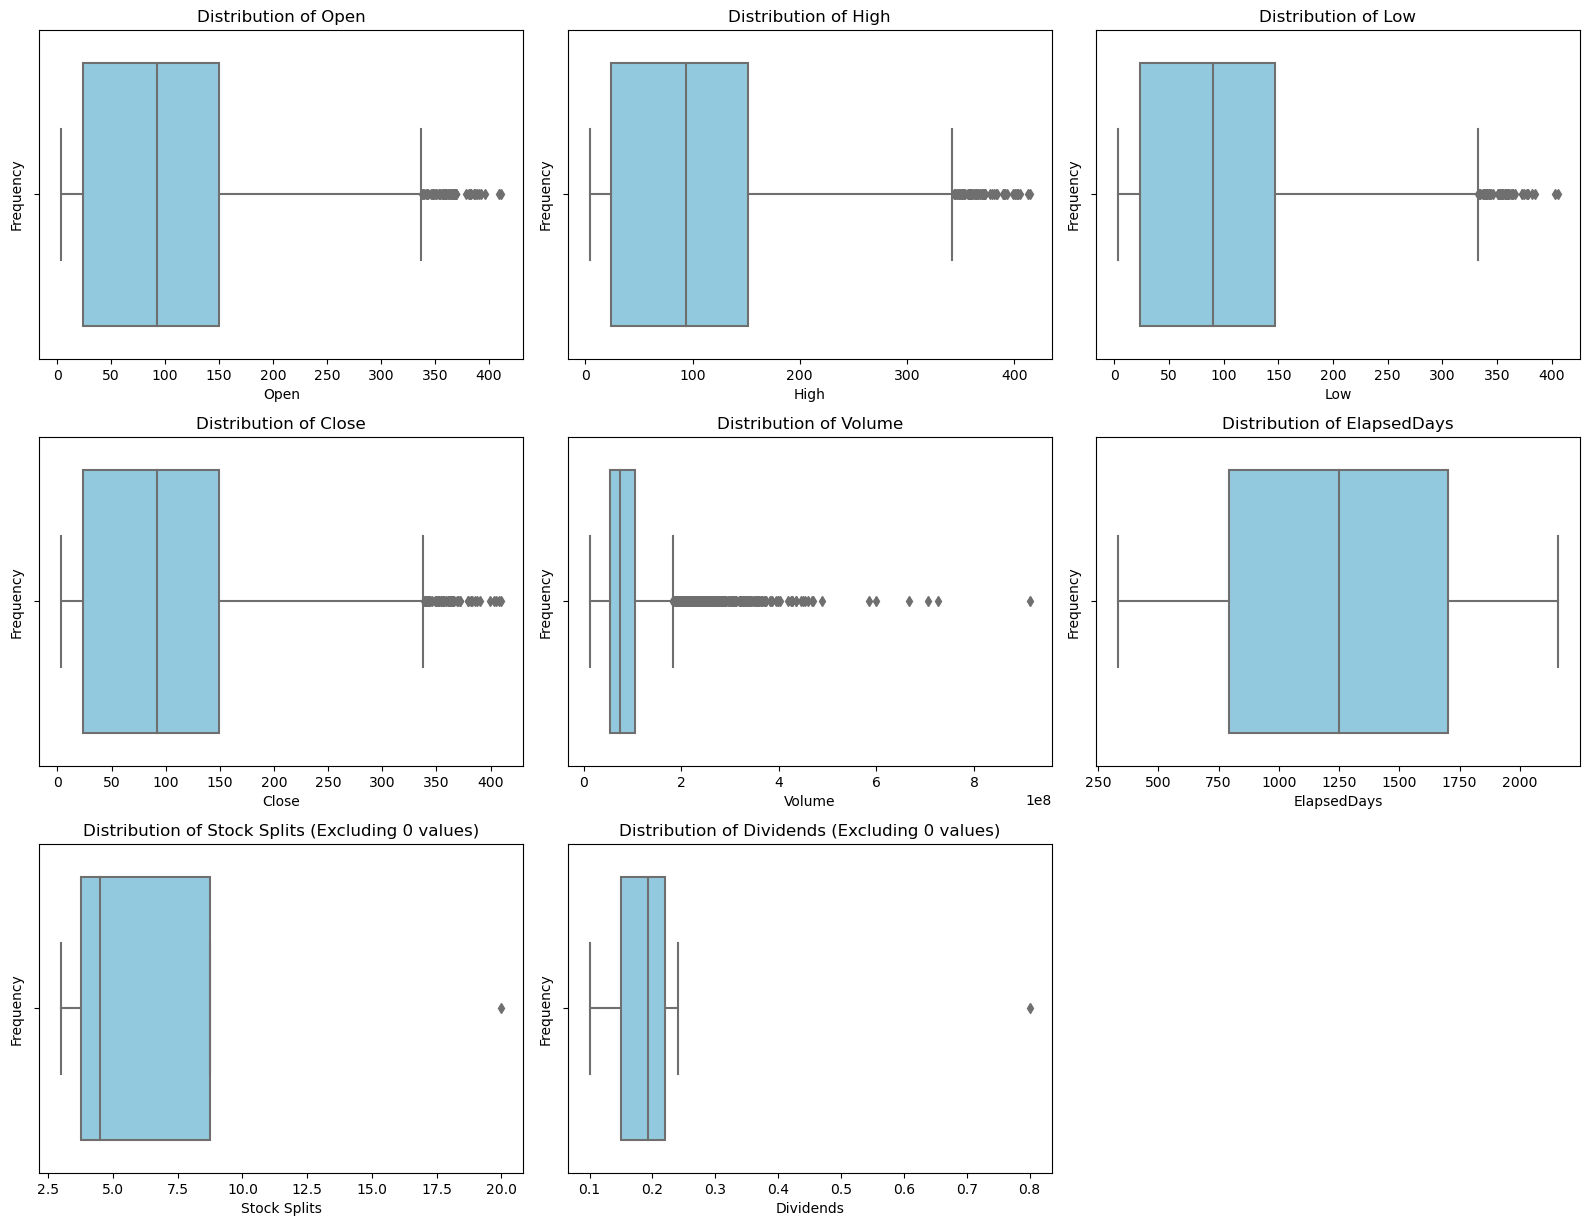

In [22]:
plt.figure(figsize=(16, 16))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 3, i)  
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

for i, col in enumerate(exeption_columns, len(numerical_columns) + 1):
    plt.subplot(4, 3, i)  
    filtered_data = df[df[col] > 0]  # Filter out 0 values
    sns.boxplot(x=filtered_data[col], color='skyblue')  
    plt.title(f'Distribution of {col} (Excluding 0 values)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

Same as the explanation before the plots show a similar result

## Companies Close Price and Volume Distributions

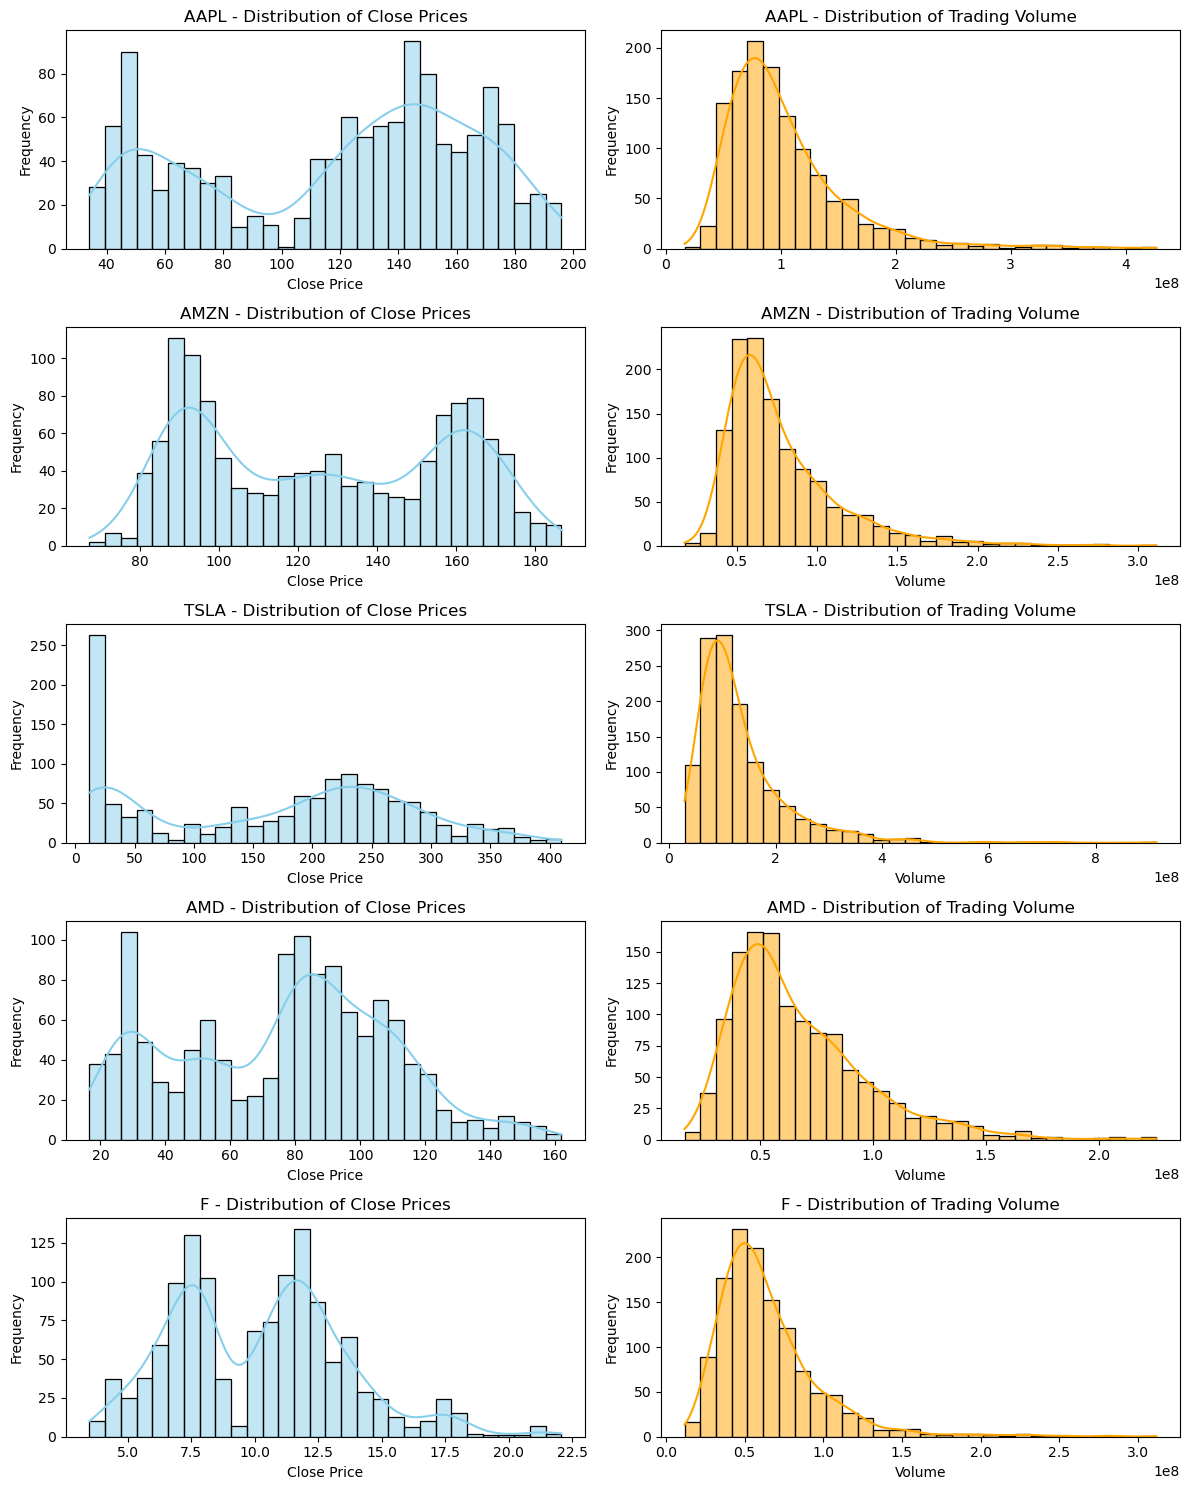

In [23]:
companies = df['Company'].unique()
fig, axes = plt.subplots(len(companies), 2, figsize=(12, len(companies) * 3), sharex=False)

# Loop through each company
for i, company in enumerate(companies):
    # Filter the data for the current company
    subset = df[df['Company'] == company]
    
    # Plot Close price distribution (Histogram + KDE)
    sns.histplot(subset['Close'], kde=True, ax=axes[i, 0], color='skyblue', bins=30)
    axes[i, 0].set_title(f'{company} - Distribution of Close Prices')
    axes[i, 0].set_xlabel('Close Price')
    axes[i, 0].set_ylabel('Frequency')

    # Plot Volume distribution (Histogram + KDE)
    sns.histplot(subset['Volume'], kde=True, ax=axes[i, 1], color='orange', bins=30)
    axes[i, 1].set_title(f'{company} - Distribution of Trading Volume')
    axes[i, 1].set_xlabel('Volume')
    axes[i, 1].set_ylabel('Frequency')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

Overall the companies follow a similar distribution except TSLA and F, where we can see that TSLA has a high frequency of low close prices in comparison to its range and Ford (F) where their range is starts from around 5.0 to 22.5

## Distribution for Categorical Features

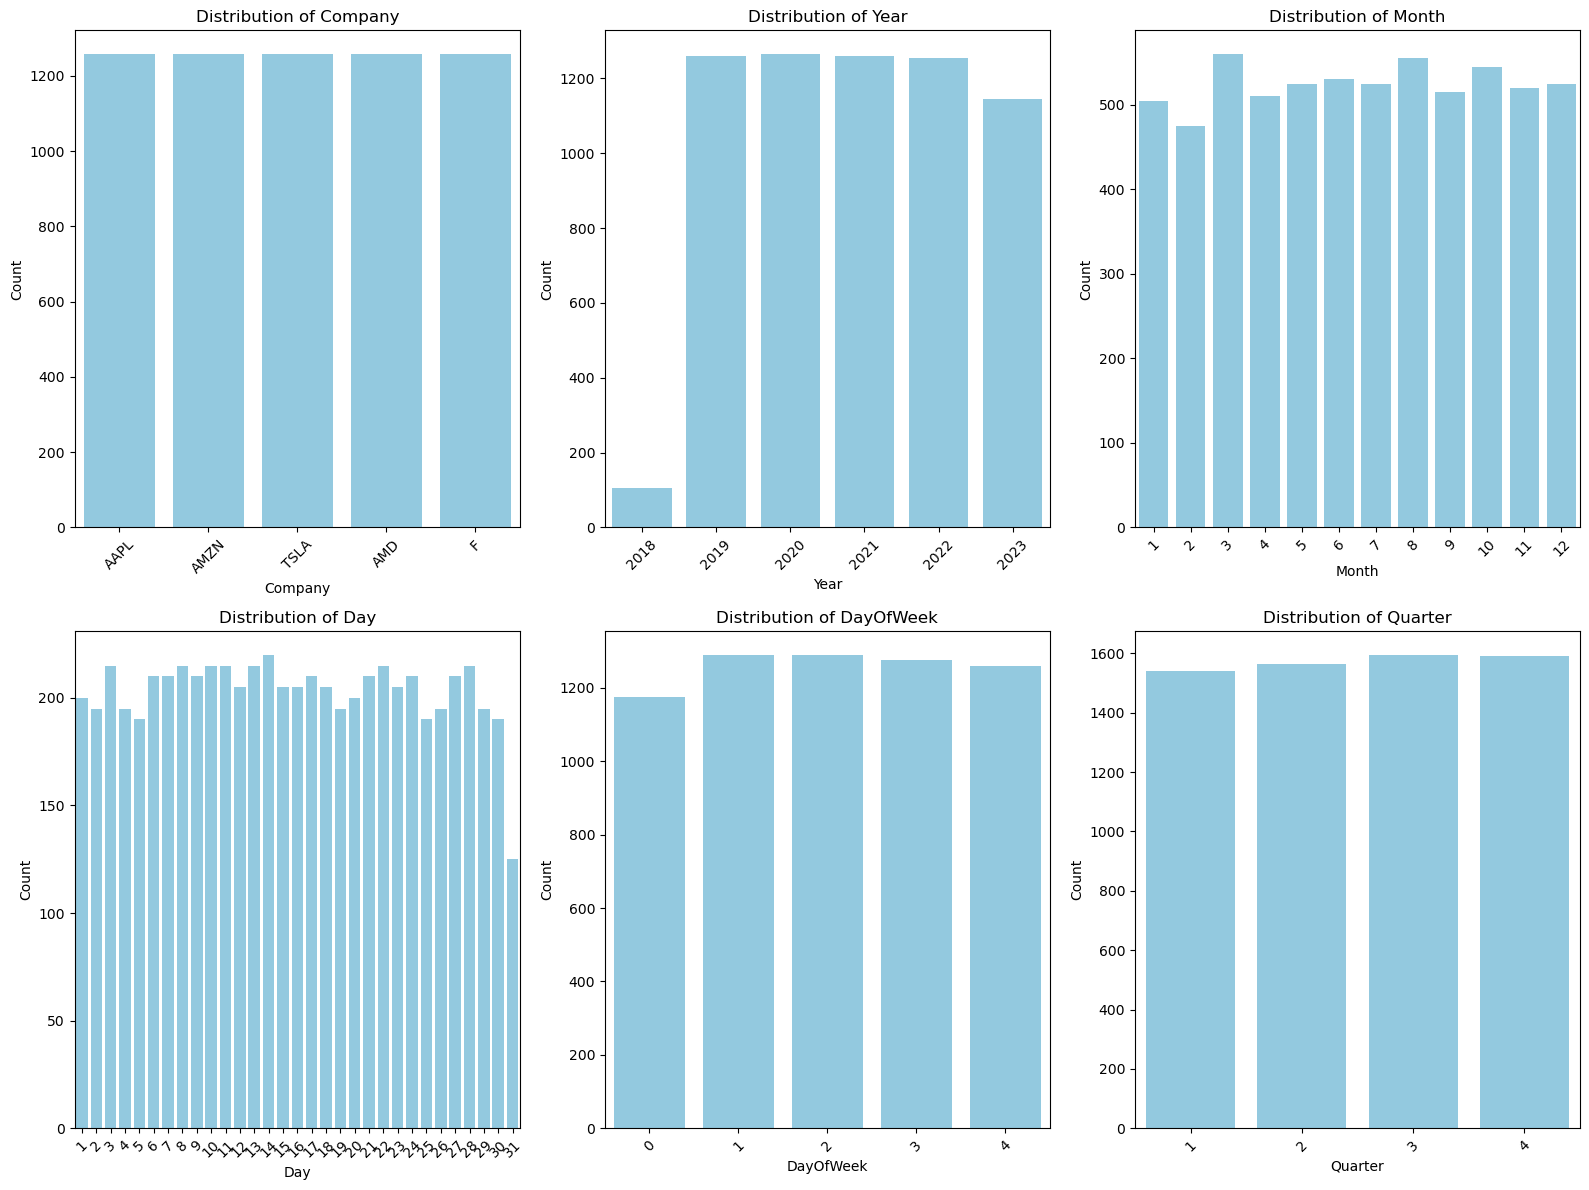

In [24]:
plt.figure(figsize=(16, 12))

# Plotting the categorical features
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    
    # Plot the countplot with hue for each company (if relevant)
    if col == 'Company':  # Only apply hue to 'Company' column
        sns.countplot(data=df, x=col, color= 'skyblue')  # Use hue to differentiate companies
    else:
        sns.countplot(data=df, x=col, color= 'skyblue')  # No hue for other columns

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate labels for better readability

# Adjust the layout for categorical plots
plt.tight_layout()

# Show the plots
plt.show()

Shows the distribution of companies which is split equally, and days/time based columns that are just the same ones just split into different columns so makes sense that it is visualized similar

# Data Preprocessing

## Correlation Matrix

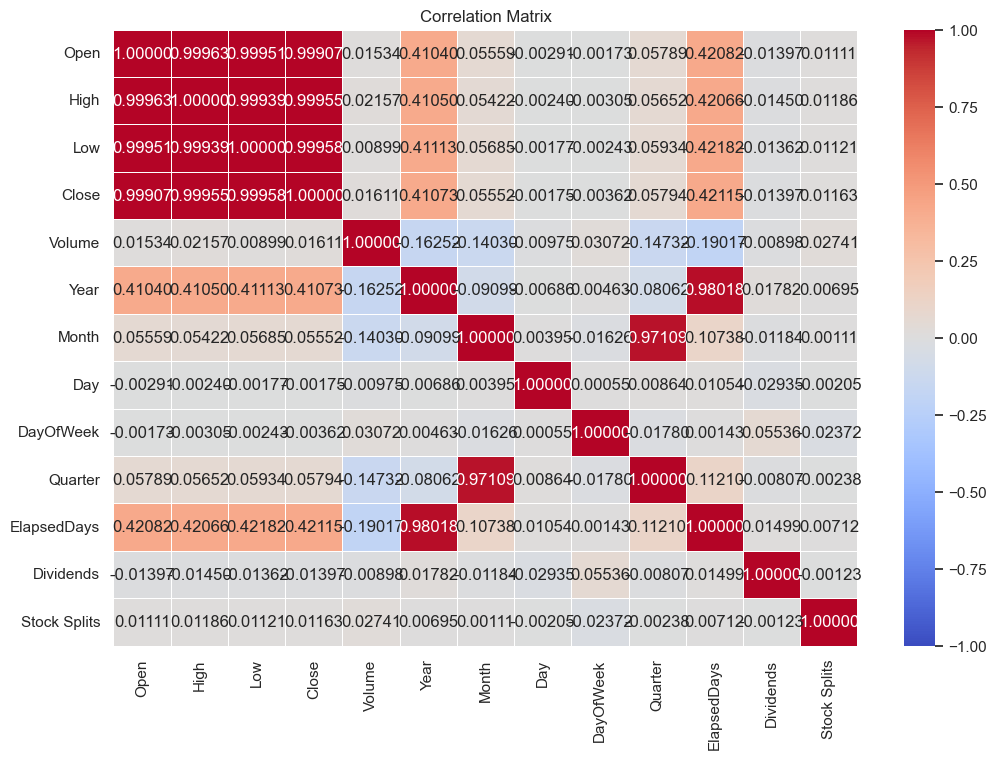

In [25]:
matrix_col = ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'ElapsedDays', 'Dividends', 'Stock Splits']

# Select only the numerical columns from the DataFrame
numerical_data = df[matrix_col]

# Calculate the correlation matrix
corr_matrix = numerical_data.corr()

# Set up the plot size and style
plt.figure(figsize=(12, 8))
sns.set(style='white')

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.5f', linewidths=0.5, vmin=-1, vmax=1)

# Set title and labels
plt.title('Correlation Matrix')
plt.show()

We can see from the correlation matrix above a few of my hypothesis are supported such as Open, High, Low and Close Columns are dependent of eachother (multicollinearity). As well as Year-ElapsedDays, Month-Quarter, Day-DayOfWeek.

## Feature Selection

In [26]:
# Define a list of columns to loop through
columns_to_add = ['Open', 'High', 'Low', 'Volume','Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Dividends', 'Stock Splits']

# Placeholder for initial base model without any additional columns
base_model = sm.tsa.SARIMAX(df['Close'], order=(1, 1, 1))  # Adjust with your ARIMAX order
base_results = base_model.fit()

# Function to extract results
def get_results(results, model_name="Base Model"):
    # Calculate residual variance (sigma²)
    residuals = results.resid
    sigma2 = residuals.var()  # Calculate variance of residuals
    
    return {
        'Model': model_name,
        'Log Likelihood': results.llf,
        'AIC': results.aic,
        'BIC': results.bic,
        'Sigma² (Residual Variance)': sigma2
    }

# Store results in a list
results_list = []

# Add the base model results (without additional columns)
results_list.append(get_results(base_results, model_name="Base Model (No Columns)"))

# Loop through columns and fit ARIMAX model with each additional column
for column in columns_to_add:
    # Create the model with the target and the additional column
    model = sm.tsa.SARIMAX(df['Close'], exog=df[[column]], order=(1, 1, 1))  # Adjust with your ARIMAX order
    results = model.fit()
    
    # Store the results for the current model
    results_list.append(get_results(results, model_name=f"Model with {column}"))

# Create DataFrame from the results list
results_df = pd.DataFrame(results_list)
results_df

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84681D+00    |proj g|=  1.69885D+00

At iterate    5    f=  5.67284D+00    |proj g|=  4.26946D-02

At iterate   10    f=  5.63510D+00    |proj g|=  1.54237D-02

At iterate   15    f=  5.62784D+00    |proj g|=  1.25300D-02

At iterate   20    f=  5.61722D+00    |proj g|=  1.75669D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   6.618D-06   5.617D+00
  F =   5.6170357038785852     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.65726D+00    |proj g|=  1.05197D+00

At iterate   10    f=  2.65455D+00    |proj g|=  2.49524D-01

At iterate   15    f=  2.64291D+00    |proj g|=  2.59170D+00

At iterate   20    f=  2.59653D+00    |proj g|=  2.14424D-01

At iterate   25    f=  2.59587D+00    |proj g|=  3.63427D-01

At iterate   30    f=  2.58717D+00    |proj g|=  3.84365D-01

At iterate   35    f=  2.58479D+00    |proj g|=  3.20191D-01

At iterate   40    f=  2.58394D+00    |proj g|=  3.43568D-02

At iterate   45    f=  2.58384D+00    |proj g|=  5.64238D-03

At iterate   50    f=  2.58383D+00    |proj g|=  2.78360D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.26010D+00    |proj g|=  2.07972D+00

At iterate   10    f=  2.25238D+00    |proj g|=  7.83520D-02

At iterate   15    f=  2.24967D+00    |proj g|=  1.05724D+00

At iterate   20    f=  2.23489D+00    |proj g|=  4.42803D-01

At iterate   25    f=  2.21096D+00    |proj g|=  1.29489D-01

At iterate   30    f=  2.20896D+00    |proj g|=  1.89789D-02

At iterate   35    f=  2.20896D+00    |proj g|=  1.06432D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     50      1     0     0   1.122D-04   2.209D+00
  F =   2.2089553502851218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.24886D+00    |proj g|=  3.72318D-01

At iterate   10    f=  2.23044D+00    |proj g|=  3.07062D+00

At iterate   15    f=  2.22543D+00    |proj g|=  1.16362D-01

At iterate   20    f=  2.20176D+00    |proj g|=  1.86285D-01

At iterate   25    f=  2.19340D+00    |proj g|=  3.00843D-01

At iterate   30    f=  2.19296D+00    |proj g|=  3.85118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     38      1     0     0   4.708D-05   2.193D+00
  F =   2.1929587411727605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     51      2     0     0   1.272D+07   6.757D+00
  F =   6.7568113908802729     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.87219D+00    |proj g|=  1.76749D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  5.69385D+00    |proj g|=  4.38042D-02

At iterate   10    f=  5.66470D+00    |proj g|=  8.58348D-03

At iterate   15    f=  5.65754D+00    |proj g|=  3.18877D-02

At iterate   20    f=  5.64778D+00    |proj g|=  2.31934D-03

At iterate   25    f=  5.64765D+00    |proj g|=  3.92652D-03

At iterate   30    f=  5.63244D+00    |proj g|=  4.21909D-02

At iterate   35    f=  5.61726D+00    |proj g|=  3.77243D-03

At iterate   40    f=  5.61700D+00    |proj g|=  6.63960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     51      1     0     0   1.661D-07   5.617D+00
  F =   5.61700024465

 This problem is unconstrained.



At iterate    5    f=  5.67288D+00    |proj g|=  4.26735D-02

At iterate   10    f=  5.63531D+00    |proj g|=  1.52942D-02

At iterate   15    f=  5.62788D+00    |proj g|=  1.40536D-02

At iterate   20    f=  5.61746D+00    |proj g|=  1.18585D-03

At iterate   25    f=  5.61704D+00    |proj g|=  2.34897D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   2.349D-06   5.617D+00
  F =   5.6170356823630589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.67284D+00    |proj g|=  4.26930D-02

At iterate   10    f=  5.63510D+00    |proj g|=  1.53968D-02

At iterate   15    f=  5.62781D+00    |proj g|=  1.31370D-02

At iterate   20    f=  5.61751D+00    |proj g|=  1.80153D-02

At iterate   25    f=  5.61703D+00    |proj g|=  1.08660D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     27      1     0     0   1.087D-06   5.617D+00
  F =   5.6170289588545961     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.67284D+00    |proj g|=  4.26947D-02

At iterate   10    f=  5.63510D+00    |proj g|=  1.54242D-02

At iterate   15    f=  5.62783D+00    |proj g|=  1.25335D-02

At iterate   20    f=  5.61722D+00    |proj g|=  1.73539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     27      1     0     0   1.226D-05   5.617D+00
  F =   5.6170326616912529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.67288D+00    |proj g|=  4.26794D-02

At iterate   10    f=  5.63527D+00    |proj g|=  1.53230D-02

At iterate   15    f=  5.62804D+00    |proj g|=  1.35529D-02

At iterate   20    f=  5.61725D+00    |proj g|=  8.81472D-04

At iterate   25    f=  5.61712D+00    |proj g|=  5.67247D-04

At iterate   30    f=  5.61703D+00    |proj g|=  4.40288D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     35      1     0     0   4.403D-06   5.617D+00
  F =   5.6170337007598361     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  5.67283D+00    |proj g|=  4.26587D-02

At iterate   10    f=  5.63508D+00    |proj g|=  1.53080D-02

At iterate   15    f=  5.62788D+00    |proj g|=  1.12230D-02

At iterate   20    f=  5.61710D+00    |proj g|=  8.74828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     25      1     0     0   5.866D-06   5.617D+00
  F =   5.6170467905848938     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.67278D+00    |proj g|=  4.25513D-02

At iterate   10    f=  5.63495D+00    |proj g|=  1.48483D-02

At iterate   15    f=  5.62592D+00    |proj g|=  1.96306D-03

At iterate   20    f=  5.61708D+00    |proj g|=  2.66558D-04

At iterate   25    f=  5.61701D+00    |proj g|=  2.30973D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   7.734D-05   5.617D+00
  F =   5.6169931979917038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Model  Log Likelihood           AIC           BIC  \
0   Base Model (No Columns)   -35331.154577  70668.309155  70688.548827   
1           Model with Open   -16252.321098  32512.642195  32539.628425   
2           Model with High   -13894.329153  27796.658307  27823.644536   
3            Model with Low   -13793.710482  27595.420964  27622.407193   
4         Model with Volume   -42500.343649  85008.687297  85035.673527   
5           Model with Year   -35330.931539  70669.863078  70696.849307   
6          Model with Month   -35331.154442  70670.308884  70697.295114   
7            Model with Day   -35331.112151  70670.224302  70697.210532   
8      Model with DayOfWeek   -35331.135442  70670.270884  70697.257113   
9        Model with Quarter   -35331.141978  70670.283956  70697.270185   
10     Model with Dividends   -35331.224313  70670.448626  70697.434855   
11  Model with Stock Splits   -35330.887215  70669.774431  70696.760660   

    Sigma² (Residual Variance)  
0                  4434.690837  
1                    10.273660  
2                     4.856257  
3                     4.703007  
4                 17518.850548  
5                  8748.833918  
6                  4434.692736  
7                  4434.641280  
8                  4434.670700  
9                  4434.660091  
10                 4434.787917  
11                 4434.390698

The feature selection is done based on the AIC BIC Log Likelihood and Sigma^2 evaluation metrics
- Open/High/Low are chosen due to their high performance as well as their correlation between the target column as well as Volume with very high log likelihood in comparison to the others all showing some sort of influencet towards "Close" column
- While LSTM models can perform well even with redundant and weak features it is recommended to remove said features as it will perform better

### Conclusion

In [27]:
columns_to_delete = ['Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Dividends', 'Stock Splits']

df = df.drop(columns=columns_to_delete)

In conclusion based on our EDA and evaluation we decided to drop these columns above

In [28]:
df.head()

Date       Open       High        Low      Close     Volume  \
0    2018-11-29  43.829761  43.863354  42.639594  43.083508  167080000   
3    2018-11-29  83.749496  84.499496  82.616501  83.678497  132264000   
6    2018-11-29  23.133333  23.166668  22.636667  22.744667   46210500   
37   2018-11-29  21.190001  21.610001  20.730000  21.430000   79853700   
259  2018-11-29   7.533947   7.590230   7.445501   7.533947   29207600   

    Company  ElapsedDays  
0      AAPL          332  
3      AMZN          332  
6      TSLA          332  
37      AMD          332  
259       F          332

# Base Line Model

We chose ARIMAX as our base line model because of its relative simplicity to predict and forecast and its ability to perform specifically on Time Series Data and its inclusion of Exogenous variables to further improve its performance. It is also easily evaluated with performance metrics and is a good comparison when compared to other more complex models

## ARIMAX with All Features

### Split dataframe Each Company

In [29]:
company_dfs = {company: df[df['Company'] == company] for company in df['Company'].unique()}

In [30]:
# Assert each data company into a new dataframe
aapl_df = company_dfs['AAPL']
amd_df = company_dfs['AMD']
amzn_df = company_dfs['AMZN']
f_df = company_dfs['F']
tsla_df = company_dfs['TSLA']

We create 5 dataframes one for each company

## Create Evaluation Dataframe

In [31]:
# Global DataFrame to store evaluation results
evaluation_data = pd.DataFrame(columns=["model_name", "company", "evaluation_type", "result"])

# Create SMAPE calculation manually
def smape(y_true, y_pred):
    """Calculate Symmetric Mean Absolute Percentage Error (SMAPE)."""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

### Function for ARIMAX to Make Modeling Easier

In [32]:
# Step 1: Prepare DataFrame and Add Derived Features
def prepare_dataframe(df):
    df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'ElapsedDays']].copy()
    df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' to datetime format
    df.set_index('Date', inplace=True)  # Set 'Date' as index
    df.dropna(inplace=True)  # Drop NaN rows caused by rolling/lags
    return df

# Step 2: Function for Train-Test Split
def train_test_split(df, split_ratio=0.8): #split 80 /20
    train_size = int(len(df) * split_ratio)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]
    return train_data, test_data

# Step 3: Function to Train ARIMAX Model
def train_sarimax(train_data, order=(1, 1, 1)):
    # Use all columns except 'Close' as exogenous variables
    exog_train = train_data[['Open', 'High', 'Low', 'Volume', 'ElapsedDays']].values
    # Fit the ARIMAX model
    model = SARIMAX(train_data['Close'], exog=exog_train, order=order)
    model_result = model.fit(disp=False)
    return model_result

# Step 4: Function to Make Predictions
def make_predictions(model_result, train_data, test_data):
    # Prepare exogenous variables for the test set
    exog_test = test_data[['Open', 'High', 'Low', 'Volume', 'ElapsedDays']].values
    # Make predictions
    predictions = model_result.predict(
        start=len(train_data), 
        end=len(train_data) + len(test_data) - 1, 
        exog=exog_test
    )
    # Add predictions to the test dataset
    test_data = test_data.copy()
    test_data['Predicted_Close'] = predictions.values
    return test_data

# Step 5: Evaluate and Plot Results
def evaluate_and_plot(train_data, test_data, company_name):
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['Close'], label="Training Data", color="blue")
    plt.plot(test_data.index, test_data['Close'], label="Actual Test Data", color="green")
    plt.plot(test_data.index, test_data['Predicted_Close'], label="Predicted Close", color="red", linestyle="--")
    plt.legend(loc="upper left")
    plt.title(f"{company_name} - ARIMAX Forecasting (All Features)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, model_name, company_name):
    """
    Calculate evaluation metrics (MSE, RMSE, R-squared, SMAPE) and append to the global DataFrame.
    
    Parameters:
    - y_true: Actual values
    - y_pred: Predicted values
    - model_name: Name of the model (str)
    - company_name: Name of the company (str)
    
    Returns:
    - metrics_dict: Dictionary of calculated metrics
    """
    global evaluation_data  # Use the global evaluation DataFrame
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    smape_value = smape(y_true, y_pred)
    
    # Create a dictionary of metrics
    metrics_dict = {
        "MSE": mse,
        "RMSE": rmse,
        "R-squared": r2,
        "SMAPE": smape_value
    }
    
    # Append metrics to the global DataFrame
    for metric_name, metric_value in metrics_dict.items():
        evaluation_data = pd.concat([
            evaluation_data,
            pd.DataFrame({
                "model_name": [model_name],
                "company": [company_name],
                "evaluation_type": [metric_name],
                "result": [metric_value]
            })
        ], ignore_index=True)
    
    # Display the metrics
    print(f"Metrics for {model_name} ({company_name}):")
    for metric_name, metric_value in metrics_dict.items():
        print(f"{metric_name}: {metric_value}")
    
    return metrics_dict


In [33]:
# Step 6: Process DataFrame
def process_dataframe(df, order=(1, 1, 1), company_name="Company"):
    """
    Processes a single DataFrame:
    1. Prepares the data
    2. Splits into train-test
    3. Trains ARIMAX model
    4. Makes predictions
    5. Evaluates and plots results
    """
    try:
        # Step 1: Prepare DataFrame
        df_prepared = prepare_dataframe(df)
        
        # Step 2: Train-Test Split
        train_data, test_data = train_test_split(df_prepared)
        print(f"Processing {company_name}...")
        print(f"Training data size: {len(train_data)}")
        print(f"Test data size: {len(test_data)}")
        
        # Step 3: Train ARIMAX Model
        model_result = train_sarimax(train_data, order)
        
        # Step 4: Make Predictions
        test_data = make_predictions(model_result, train_data, test_data)
        
        # Step 5: Evaluate Model
        y_true = test_data['Close']
        y_pred = test_data['Predicted_Close']
        calculate_metrics(y_true, y_pred, model_name="ARIMAX All Features", company_name= company_name)

        # Step 6: Plot Results
        evaluate_and_plot(train_data, test_data, company_name)
        
        return test_data, model_result
    except Exception as e:
        print(f"Error processing {company_name}: {e}")
        return None, None


### Apply Functions

Processing AAPL...
Training data size: 1006
Test data size: 252
Metrics for ARIMAX All Features (AAPL):
MSE: 26.074402927949208
RMSE: 5.106310108870123
R-squared: 0.9254594943186705
SMAPE: 2.5458519480150477


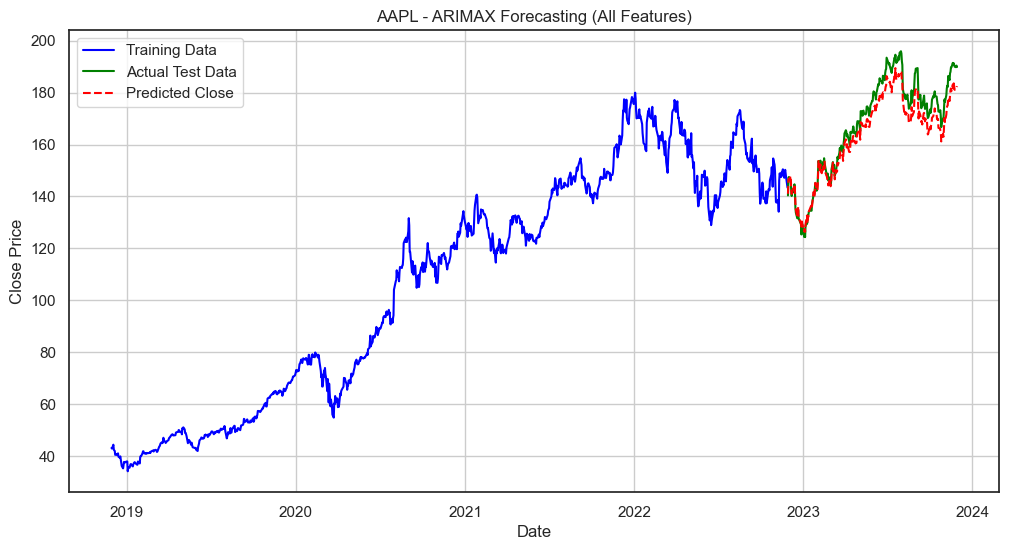

Processing AMD...
Training data size: 1006
Test data size: 252
Metrics for ARIMAX All Features (AMD):
MSE: 21.499119813634007
RMSE: 4.6367143338396435
R-squared: 0.9280322100505819
SMAPE: 3.8423702589334057


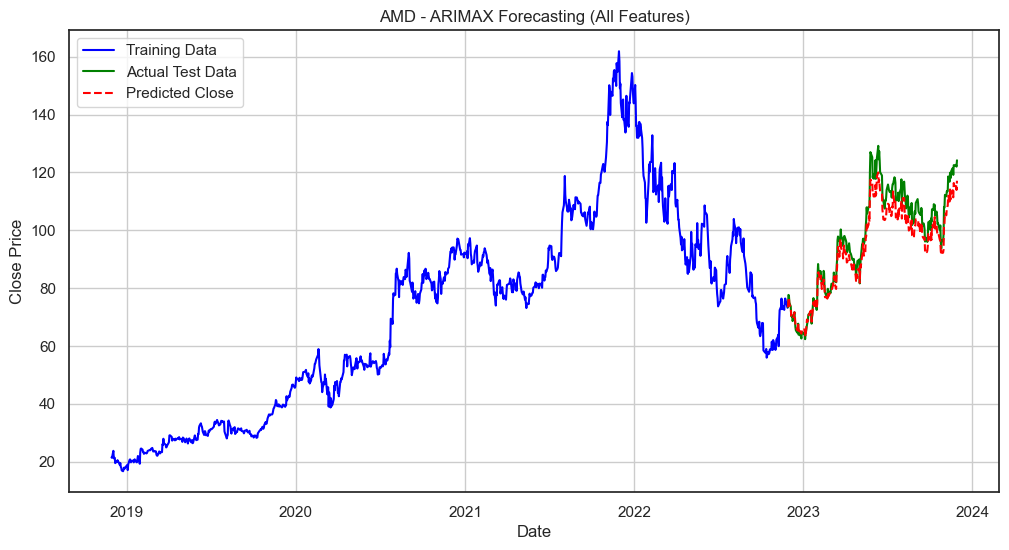

Processing AMZN...
Training data size: 1006
Test data size: 252
Metrics for ARIMAX All Features (AMZN):
MSE: 71.44509431467338
RMSE: 8.452519997886629
R-squared: 0.7997857321248454
SMAPE: 5.939856053199128


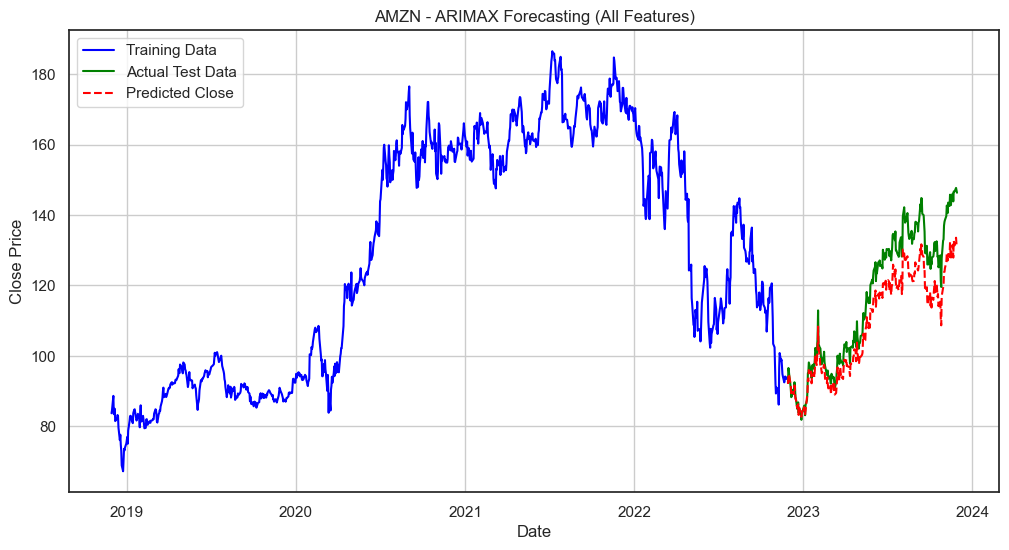

Processing F...
Training data size: 1006
Test data size: 252
Metrics for ARIMAX All Features (F):
MSE: 0.2788325331402048
RMSE: 0.5280459574129933
R-squared: 0.7707621395685849
SMAPE: 3.834266819744947


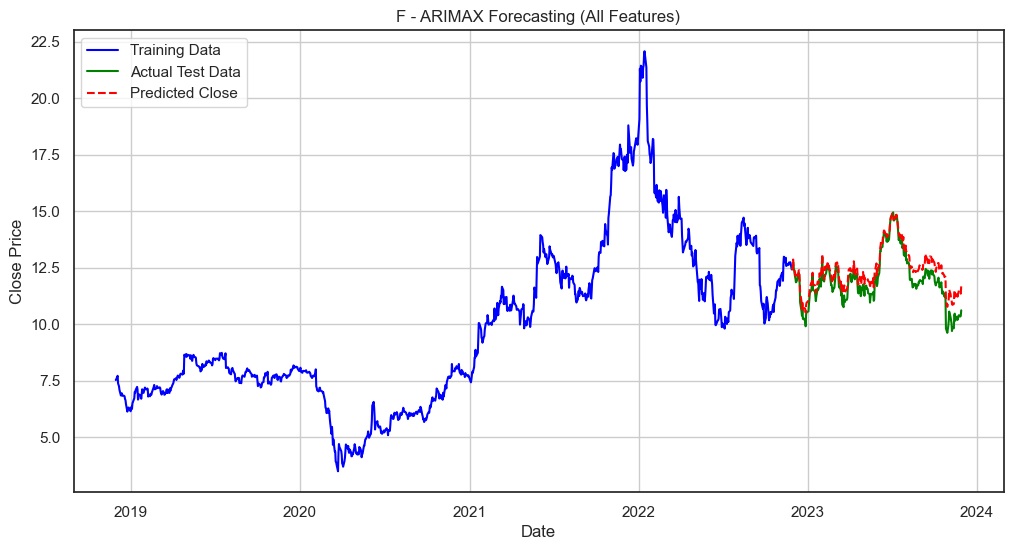

Processing TSLA...
Training data size: 1006
Test data size: 252
Metrics for ARIMAX All Features (TSLA):
MSE: 233.85904435431527
RMSE: 15.292450567332734
R-squared: 0.8835015797852386
SMAPE: 5.90141570882144


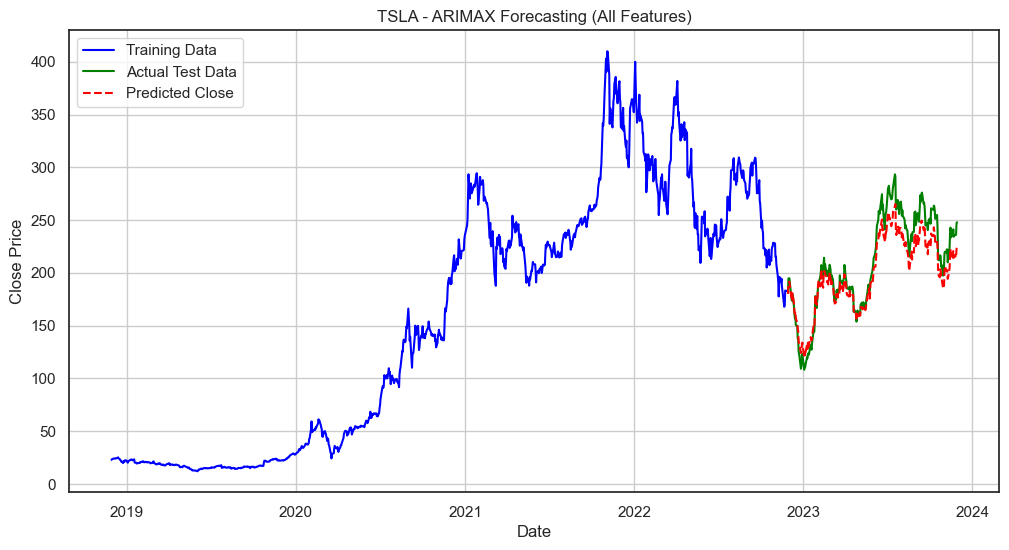

Results for AAPL:
                 Close        Open        High         Low     Volume  \
Date                                                                    
2022-11-29  140.385315  143.487968  144.005082  139.569881   83763800   
2022-11-30  147.207169  140.614017  147.893336  139.768751  111380900   
2022-12-01  147.485626  147.386191  148.301076  145.795079   71250400   
2022-12-02  146.988403  145.148696  147.177350  144.840406   65447400   
2022-12-05  145.814972  146.948635  150.081120  144.959752   68826400   

            ElapsedDays  Predicted_Close  
Date                                      
2022-11-29         1793       141.013795  
2022-11-30         1794       146.601080  
2022-12-01         1795       146.653853  
2022-12-02         1796       146.512571  
2022-12-05         1799       147.901643  
Results for AMD:
                Close       Open       High        Low    Volume  ElapsedDays  \
Date                                                                   

In [34]:
# Step 7: Apply to Multiple DataFrames
def process_all_dataframes(dataframes, order=(1, 1, 1)):

    results = {}
    for company_name, df in dataframes.items():
        try:
            test_data, model_result = process_dataframe(df, order=order, company_name=company_name)
            if test_data is not None:
                results[company_name] = {
                    'test_data': test_data,
                    'model_result': model_result
                }
        except Exception as e:
            print(f"Error processing {company_name}: {e}")
    return results

# Example Usage
if __name__ == "__main__":
    # Replace these DataFrames with actual stock price data
    # Example DataFrames: AAPL, AMD, AMZN, F, TSLA
    dataframes = {
        'AAPL': aapl_df,
        'AMD': amd_df,
        'AMZN': amzn_df,
        'F': f_df,
        'TSLA': tsla_df
    }

    # Process all dataframes
    results = process_all_dataframes(dataframes)

    # Display results for each company
    for company, result in results.items():
        print(f"Results for {company}:")
        print(result['test_data'].head())

### Evaluation

In [35]:
evaluation_data[evaluation_data["model_name"] == "ARIMAX All Features"]

model_name company evaluation_type      result
0   ARIMAX All Features    AAPL             MSE   26.074403
1   ARIMAX All Features    AAPL            RMSE    5.106310
2   ARIMAX All Features    AAPL       R-squared    0.925459
3   ARIMAX All Features    AAPL           SMAPE    2.545852
4   ARIMAX All Features     AMD             MSE   21.499120
5   ARIMAX All Features     AMD            RMSE    4.636714
6   ARIMAX All Features     AMD       R-squared    0.928032
7   ARIMAX All Features     AMD           SMAPE    3.842370
8   ARIMAX All Features    AMZN             MSE   71.445094
9   ARIMAX All Features    AMZN            RMSE    8.452520
10  ARIMAX All Features    AMZN       R-squared    0.799786
11  ARIMAX All Features    AMZN           SMAPE    5.939856
12  ARIMAX All Features       F             MSE    0.278833
13  ARIMAX All Features       F            RMSE    0.528046
14  ARIMAX All Features       F       R-squared    0.770762
15  ARIMAX All Features       F           SMAPE    3.834267
16  ARIMAX All Features    TSLA             MSE  233.859044
17  ARIMAX All Features    TSLA            RMSE   15.292451
18  ARIMAX All Features    TSLA       R-squared    0.883502
19  ARIMAX All Features    TSLA           SMAPE    5.901416

From the evaluation metrics here we can see that overall the companies performed somewhat well with exceptions such as TSLA performing horribly and Ford performing extremely well with very low MSE/RMSE/SMAPE value and a pretty high R-Squared value

## ARIMAX With  Close Column Only

Now, we want to experiment to use ARIMAX with Column Close only to compare the results

### Split Dataframe Each Company

In [36]:
aapl_df = company_dfs['AAPL']
amd_df = company_dfs['AMD']
amzn_df = company_dfs['AMZN']
f_df = company_dfs['F']
tsla_df = company_dfs['TSLA']

### Function for ARIMAX Model

In [37]:
# Step 1: Prepare DataFrame and Add Derived Features
def prepare_dataframe(df):
    df = df[['Close', 'Date']].copy()
    df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' to datetime format
    df.set_index('Date', inplace=True)  # Set 'Date' as index

    # Add derived features
    df['Rolling_Mean_7'] = df['Close'].rolling(window=7).mean()
    df['Rolling_Std_7'] = df['Close'].rolling(window=7).std()
    df['Lag_1'] = df['Close'].shift(1)
    df.dropna(inplace=True)  # Drop NaN rows caused by rolling/lags
    
    return df

# Step 2: Train-Test Split
def train_test_split(df, split_ratio=0.8):
    train_size = int(len(df) * split_ratio)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]
    return train_data, test_data

# Step 3: Train ARIMAX Model
def train_sarimax(train_data, order=(1, 1, 1)):
    exog_train = train_data[['Rolling_Mean_7', 'Rolling_Std_7', 'Lag_1']]
    model = SARIMAX(train_data['Close'], exog=exog_train, order=order)
    model_result = model.fit(disp=False)
    return model_result

# Step 4: Make Predictions
def make_predictions(model_result, train_data, test_data):
    exog_test = test_data[['Rolling_Mean_7', 'Rolling_Std_7', 'Lag_1']]
    predictions = model_result.predict(
        start=len(train_data), 
        end=len(train_data) + len(test_data) - 1, 
        exog=exog_test
    )
    test_data = test_data.copy()
    test_data['Predicted_Close'] = predictions.values
    return test_data

# Step 5: Evaluate and Plot Results
def evaluate_and_plot(train_data, test_data,company_name):
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['Close'], label="Training Data", color="blue")
    plt.plot(test_data.index, test_data['Close'], label="Actual Test Data", color="green")
    plt.plot(test_data.index, test_data['Predicted_Close'], label="Predicted Close", color="red", linestyle="--")
    plt.legend(loc="upper left")
    plt.title(f"{company_name} - ARIMAX Forecasting (Close Column Only)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid()
    plt.show()

# Step 6: Evaluation metrics
def calculate_metrics(y_true, y_pred, model_name, company_name):
    global evaluation_data  # Use the global evaluation DataFrame
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    smape_value = smape(y_true, y_pred)
    
    # Create a dictionary of metrics
    metrics_dict = {
        "MSE": mse,
        "RMSE": rmse,
        "R-squared": r2,
        "SMAPE": smape_value
    }
    
    # Append metrics to the global DataFrame
    for metric_name, metric_value in metrics_dict.items():
        evaluation_data = pd.concat([
            evaluation_data,
            pd.DataFrame({
                "model_name": [model_name],
                "company": [company_name],
                "evaluation_type": [metric_name],
                "result": [metric_value]
            })
        ], ignore_index=True)
    
    # Display the metrics
    print(f"Metrics for {model_name} ({company_name}):")
    for metric_name, metric_value in metrics_dict.items():
        print(f"{metric_name}: {metric_value}")
    
    return metrics_dict


In [38]:
# Step 7: Fucntion for All
def process_dataframe(df, order=(1, 1, 1), company_name="Company"):
    try:
        # Step 1: Prepare DataFrame
        df_prepared = prepare_dataframe(df)
        
        # Step 2: Train-Test Split
        train_data, test_data = train_test_split(df_prepared)
        print(f"Processing {company_name}...")
        print(f"Training data size: {len(train_data)}")
        print(f"Test data size: {len(test_data)}")
        
        # Step 3: Train ARIMAX Model
        model_result = train_sarimax(train_data, order)
        
        # Step 4: Make Predictions
        test_data = make_predictions(model_result, train_data, test_data)
        
        # Step 5: Evaluate Model
        y_true = test_data['Close']
        y_pred = test_data['Predicted_Close']
        calculate_metrics(y_true, y_pred, model_name="ARIMAX Close Column Only", company_name=company_name)

        # Step 6: Plot Results
        evaluate_and_plot(train_data, test_data, company_name)
        
        return test_data, model_result
    except Exception as e:
        print(f"Error processing {company_name}: {e}")
        return None, None


### Apply Functions

Processing AAPL...
Training data size: 1001
Test data size: 251
Metrics for ARIMAX Close Column Only (AAPL):
MSE: 71.03675115151346
RMSE: 8.428330270671259
R-squared: 0.7960649490103057
SMAPE: 4.365029508410136


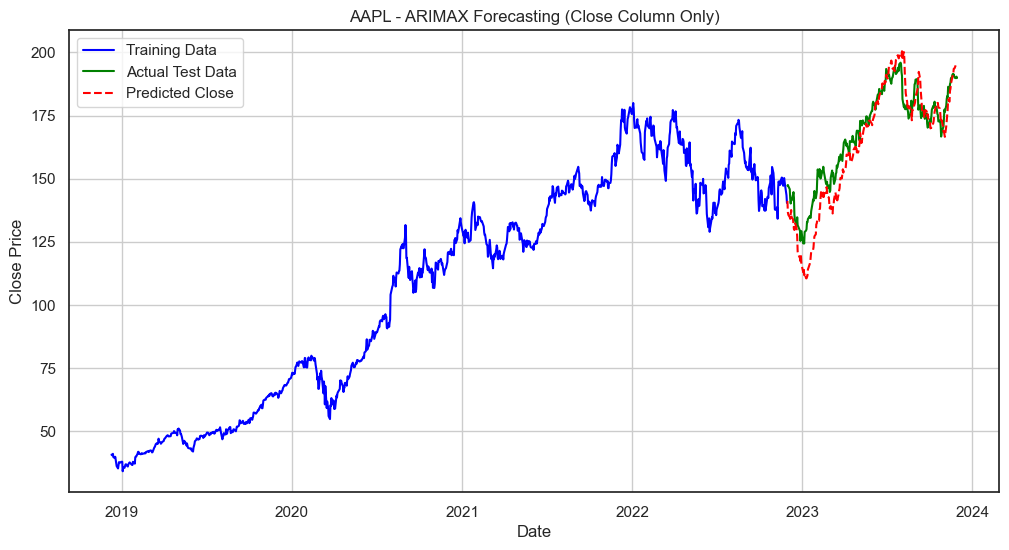

Processing AMD...
Training data size: 1001
Test data size: 251
Metrics for ARIMAX Close Column Only (AMD):
MSE: 59.06599961536855
RMSE: 7.685440756089956
R-squared: 0.8015503825140432
SMAPE: 6.191837848096172


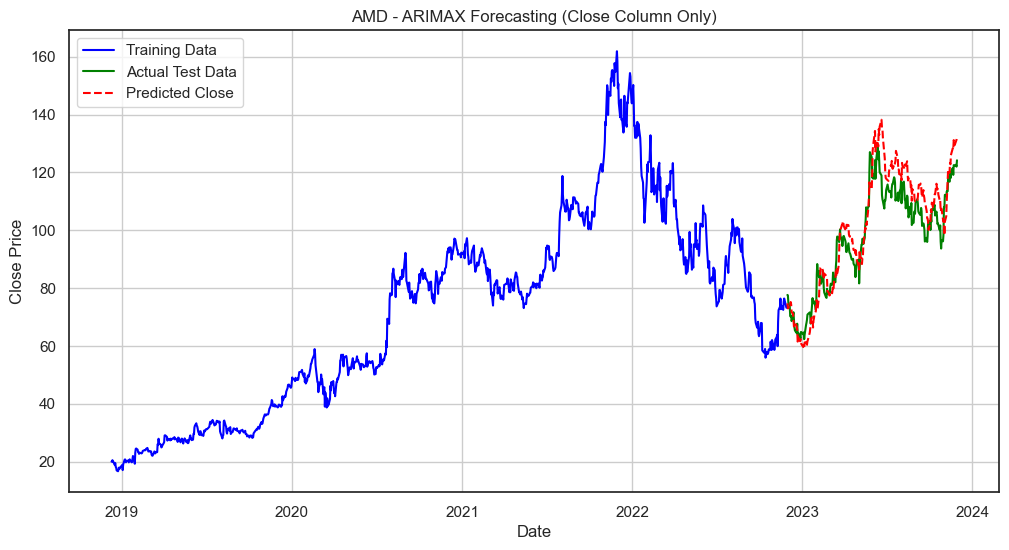

Processing AMZN...
Training data size: 1001
Test data size: 251
Metrics for ARIMAX Close Column Only (AMZN):
MSE: 100.55706628882717
RMSE: 10.027814631754378
R-squared: 0.717566158688774
SMAPE: 6.198832473170771


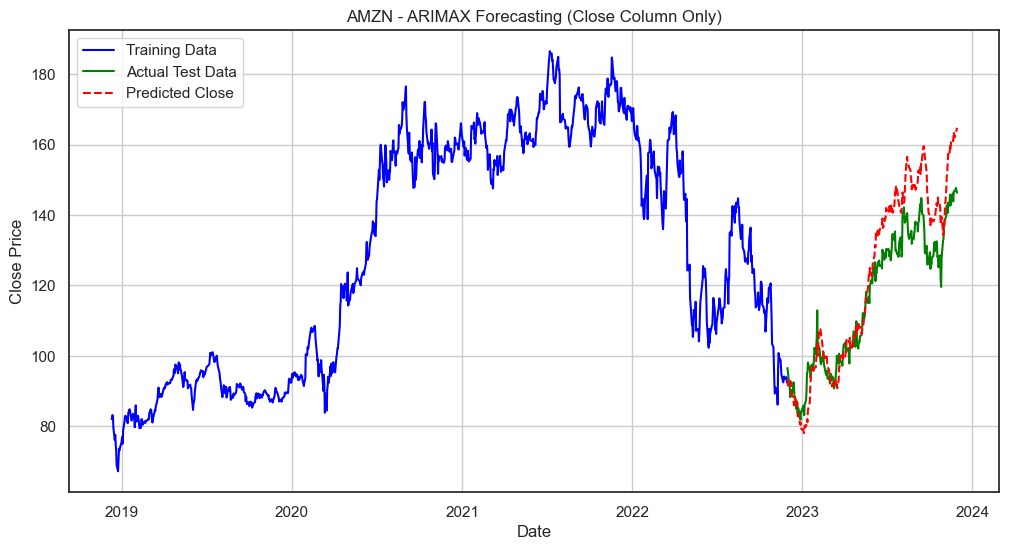

Processing F...
Training data size: 1001
Test data size: 251
Metrics for ARIMAX Close Column Only (F):
MSE: 0.4597790652094235
RMSE: 0.6780701034623363
R-squared: 0.6231918615358119
SMAPE: 4.784676943960261


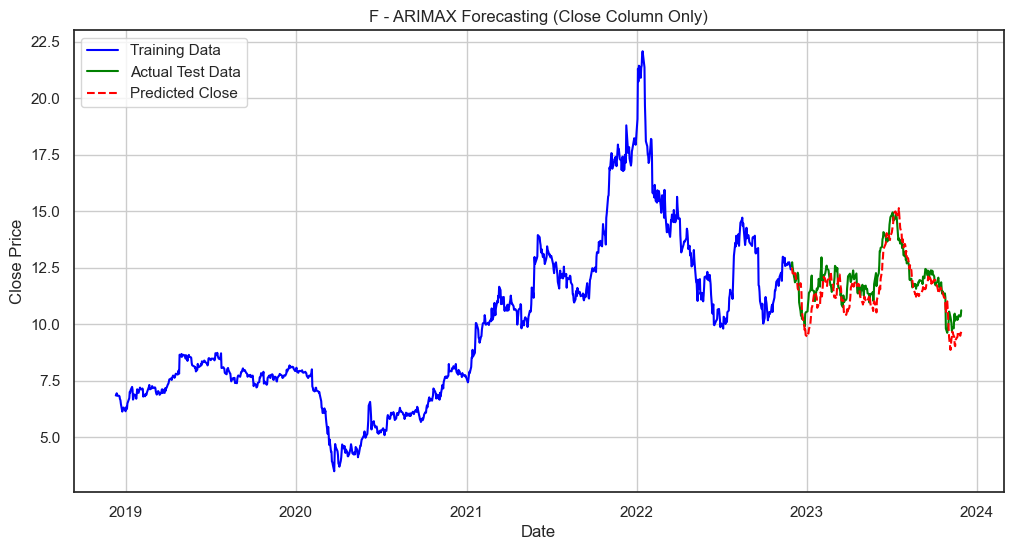

Processing TSLA...
Training data size: 1001
Test data size: 251
Metrics for ARIMAX Close Column Only (TSLA):
MSE: 412.141974431425
RMSE: 20.30128011804736
R-squared: 0.7951708522237426
SMAPE: 7.6936757961960245


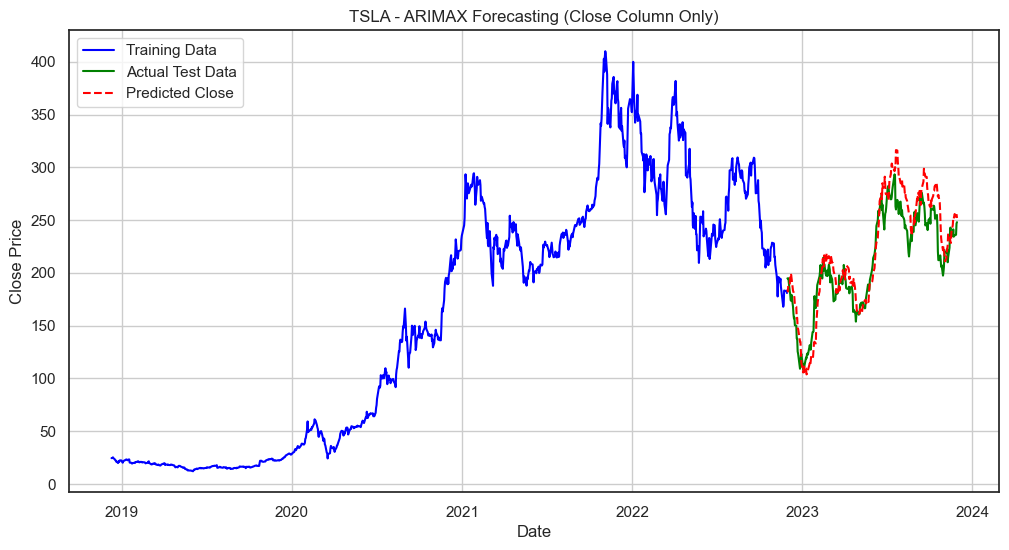

Results for AAPL:
                 Close  Rolling_Mean_7  Rolling_Std_7       Lag_1  \
Date                                                                
2022-11-30  147.207169      146.437197       3.426855  140.385315   
2022-12-01  147.485626      146.479817       3.439571  147.207169   
2022-12-02  146.988403      146.143130       3.220728  147.485626   
2022-12-05  145.814972      145.512368       2.672584  146.988403   
2022-12-06  142.115646      144.773642       2.811452  145.814972   

            Predicted_Close  
Date                         
2022-11-30       141.187333  
2022-12-01       136.577088  
2022-12-02       135.654591  
2022-12-05       134.749783  
2022-12-06       134.076998  
Results for AMD:
                Close  Rolling_Mean_7  Rolling_Std_7      Lag_1  \
Date                                                              
2022-11-30  77.629997       74.780000       1.868154  73.389999   
2022-12-01  77.480003       75.497143       1.791068  77.629997   
202

In [39]:
# Step 7: Apply to Multiple DataFrames
def process_all_dataframes(dataframes, order=(1, 1, 1)):
    results = {}
    for company_name, df in dataframes.items():
        try:
            test_data, model_result = process_dataframe(df, order=order, company_name=company_name)
            if test_data is not None:
                results[company_name] = {
                    'test_data': test_data,
                    'model_result': model_result
                }
        except Exception as e:
            print(f"Error processing {company_name}: {e}")
    return results

# Example Usage
if __name__ == "__main__":
    dataframes = {
        'AAPL': aapl_df,
        'AMD': amd_df,
        'AMZN': amzn_df,
        'F': f_df,
        'TSLA': tsla_df
    }
    results = process_all_dataframes(dataframes)

    for company, result in results.items():
        print(f"Results for {company}:")
        print(result['test_data'].head())

### Evaluation

In [40]:
evaluation_data[evaluation_data["model_name"] == "ARIMAX Close Column Only"]

model_name company evaluation_type      result
20  ARIMAX Close Column Only    AAPL             MSE   71.036751
21  ARIMAX Close Column Only    AAPL            RMSE    8.428330
22  ARIMAX Close Column Only    AAPL       R-squared    0.796065
23  ARIMAX Close Column Only    AAPL           SMAPE    4.365030
24  ARIMAX Close Column Only     AMD             MSE   59.066000
25  ARIMAX Close Column Only     AMD            RMSE    7.685441
26  ARIMAX Close Column Only     AMD       R-squared    0.801550
27  ARIMAX Close Column Only     AMD           SMAPE    6.191838
28  ARIMAX Close Column Only    AMZN             MSE  100.557066
29  ARIMAX Close Column Only    AMZN            RMSE   10.027815
30  ARIMAX Close Column Only    AMZN       R-squared    0.717566
31  ARIMAX Close Column Only    AMZN           SMAPE    6.198832
32  ARIMAX Close Column Only       F             MSE    0.459779
33  ARIMAX Close Column Only       F            RMSE    0.678070
34  ARIMAX Close Column Only       F       R-squared    0.623192
35  ARIMAX Close Column Only       F           SMAPE    4.784677
36  ARIMAX Close Column Only    TSLA             MSE  412.141974
37  ARIMAX Close Column Only    TSLA            RMSE   20.301280
38  ARIMAX Close Column Only    TSLA       R-squared    0.795171
39  ARIMAX Close Column Only    TSLA           SMAPE    7.693676

In this model we decided to see how the ARIMAX model would perform with only the "Close" column feature as it is our target column as well but it did perform better according to our believes instead in almost all scenarios it performed much worse

# Proposed Model

We chose LSTM as our proposed model due to its ability to perform similarly to ARIMAX models yet outperform it where it matters such as LSTM's ability to handle a variety of forecasting horizons such as short-term predicitons i.e daily/weekly/hourly and long term patterns like seasonal trends and such. It can also be integrated with other advanced techniques such as creating a hybrid model, and another reason is that LSTM models have been used widely/commonly in the field of financial forecasting.

## LSTM with All Features

Our first LSTM model will fit all selected features into our model

### Split Data

#### By Each Company

In [41]:
aapl_df = company_dfs['AAPL']
amd_df = company_dfs['AMD']
amzn_df = company_dfs['AMZN']
f_df = company_dfs['F']
tsla_df = company_dfs['TSLA']

#### Splitting each company into train n test

In [42]:

split_index = int(len(aapl_df) * 0.8)
aapl_train = aapl_df[:split_index]
aapl_test = aapl_df[split_index:]

amd_train = amd_df[:split_index]
amd_test = amd_df[split_index:]

amzn_train = amzn_df[:split_index]
amzn_test = amzn_df[split_index:]

f_train = f_df[:split_index]
f_test = f_df[split_index:]

tsla_train = tsla_df[:split_index]
tsla_test = tsla_df[split_index:]

### Scaling Data by each company

In [43]:
def scale_data(train_df, test_df):
    scaler = MinMaxScaler()
    # Fit the scaler to the training data and transform it
    train_scaled = scaler.fit_transform(train_df)
    # Transform the test data using the already fitted scaler
    test_scaled = scaler.transform(test_df)
    
    # Convert back to DataFrame for easier handling
    train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns)
    test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns)
    
    return train_scaled_df, test_scaled_df

# Scale the data for each company's train and test sets
aapl_train_scaled, aapl_test_scaled = scale_data(aapl_train.drop(columns=['Company','Date']), aapl_test.drop(columns=['Company','Date']))
amd_train_scaled, amd_test_scaled = scale_data(amd_train.drop(columns=['Company','Date']), amd_test.drop(columns=['Company','Date']))
amzn_train_scaled, amzn_test_scaled = scale_data(amzn_train.drop(columns=['Company','Date']), amzn_test.drop(columns=['Company','Date']))
f_train_scaled, f_test_scaled = scale_data(f_train.drop(columns=['Company','Date']), f_test.drop(columns=['Company','Date']))
tsla_train_scaled, tsla_test_scaled = scale_data(tsla_train.drop(columns=['Company','Date']), tsla_test.drop(columns=['Company','Date']))


### LSTM Data Preparation

In [44]:
def prepare_lstm_data(scaled_df, target_column, sequence_length=60):
    """
    Prepares data for LSTM modeling.
    
    Parameters:
        scaled_df (pd.DataFrame): The scaled DataFrame containing features.
        target_column (str): The name of the target column (e.g., 'Close').
        sequence_length (int): Number of time steps to include in each sample 60 days (3 month) is the common time steps. This value has been adopted in many examples and tutorials, particularly in financial forecasting, as a convention for sequence length.
        
    Returns:
        X (numpy.ndarray): Feature array of shape (samples, sequence_length, features).
        y (numpy.ndarray): Target array of shape (samples,).
    """
    X, y = [], []
    for i in range(sequence_length, len(scaled_df)):
        X.append(scaled_df.iloc[i-sequence_length:i].values)
        y.append(scaled_df.iloc[i][target_column])
    return np.array(X), np.array(y)

X_train_tsla, y_train_tsla = prepare_lstm_data(tsla_train_scaled, target_column='Close')
X_test_tsla, y_test_tsla = prepare_lstm_data(tsla_test_scaled, target_column='Close')

X_train_aapl, y_train_aapl = prepare_lstm_data(aapl_train_scaled, target_column='Close')
X_test_aapl, y_test_aapl = prepare_lstm_data(aapl_test_scaled, target_column='Close')

X_train_amd, y_train_amd = prepare_lstm_data(amd_train_scaled, target_column='Close')
X_test_amd, y_test_amd = prepare_lstm_data(amd_test_scaled, target_column='Close')

X_train_f, y_train_f = prepare_lstm_data(f_train_scaled, target_column='Close')
X_test_f, y_test_f = prepare_lstm_data(f_test_scaled, target_column='Close')

X_train_amzn, y_train_amzn = prepare_lstm_data(amzn_train_scaled, target_column='Close')
X_test_amzn, y_test_amzn = prepare_lstm_data(amzn_test_scaled, target_column='Close')


In [45]:
# Funtion for evaluation data
def insert_lstm_results(y_true, y_pred, company_name, model_name="LSTM All Features"):
    """
    Calculate and store evaluation metrics for an LSTM model in the global evaluation DataFrame.
    Parameters:
    - y_true: Actual values
    - y_pred: Predicted values
    - company_name: Name of the company (str)
    - model_name: Name of the model (str, default: "LSTM")
    """
    global evaluation_data
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    smape_value = smape(y_true, y_pred)
    
    # Append metrics to the evaluation DataFrame
    metrics_dict = {
        "MSE": mse,
        "RMSE": rmse,
        "R-squared": r2,
        "SMAPE": smape_value
    }
    
    for metric_name, metric_value in metrics_dict.items():
        evaluation_data = pd.concat([
            evaluation_data,
            pd.DataFrame({
                "model_name": [model_name],
                "company": [company_name],
                "evaluation_type": [metric_name],
                "result": [metric_value]
            })
        ], ignore_index=True)
    
    # Return metrics for display or plotting
    return metrics_dict


### Train Data

In [46]:
# 3. Define the LSTM training function
def train_lstm_model(X_train, y_train, X_test, y_test, input_shape, epochs=50, batch_size=32):
    """
    Each LSTM layer processes different aspects of the input sequence:
    - The first LSTM layer focuses on immediate patterns in the data (e.g., short-term trends).
    - The second LSTM layer captures more complex or longer-term dependencies.
    - Adding Dropout after both layers ensures that each level of learned representation is properly regularized.
    - optimizer='adam': Adaptive Moment Estimation (Adam) optimizer, commonly used for its efficiency and effectiveness in deep learning.
    - loss='mean_squared_error': The loss function minimizes the squared differences between actual and predicted values.
    """    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape)) # first layer lstm
    model.add(Dropout(0.2)) # prevent overfit by set 0 20% of data randomly 
    model.add(LSTM(units=50, return_sequences=False)) # second layer
    model.add(Dropout(0.2)) # prevent overfit by set 0 20% of data randomly 
    model.add(Dense(units=25, activation='relu')) # Fully connected layer with 25 neurons and ReLU activation. It captures non-linear relationships.
    model.add(Dense(units=1))# one prediction output
    model.compile(optimizer='adam', loss='mean_squared_error') # MSE for priority loss

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_split=0.2, verbose=1) # epochs  = number of iteration, batch_size = number of samples training each batch, 20% for validation

    y_pred = model.predict(X_test) #making prediction
    return model, history, y_pred


# Company datasets
companies = {
    'TSLA': (X_train_tsla, y_train_tsla, X_test_tsla, y_test_tsla),
    'AAPL': (X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl),
    'AMD': (X_train_amd, y_train_amd, X_test_amd, y_test_amd),
    'F': (X_train_f, y_train_f, X_test_f, y_test_f),
    'AMZN': (X_train_amzn, y_train_amzn, X_test_amzn, y_test_amzn)
}
# Store results for all companies
results = {}

# 5. Main execution: Train and evaluate models for each company
for company, (X_train, y_train, X_test, y_test) in companies.items():
    print(f"Training model for {company}...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Train the LSTM model
    model, history, y_pred = train_lstm_model(X_train, y_train, X_test, y_test, input_shape)
    
    # Evaluate metrics and store results
    metrics = insert_lstm_results(y_test, y_pred, company_name=company, model_name="LSTM All Features")
    results[company] = {'model': model, 'history': history, 'y_test': y_test, 'y_pred': y_pred, 'metrics': metrics}




Training model for TSLA...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1198 - val_loss: 0.0124
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━

### Plotting the result

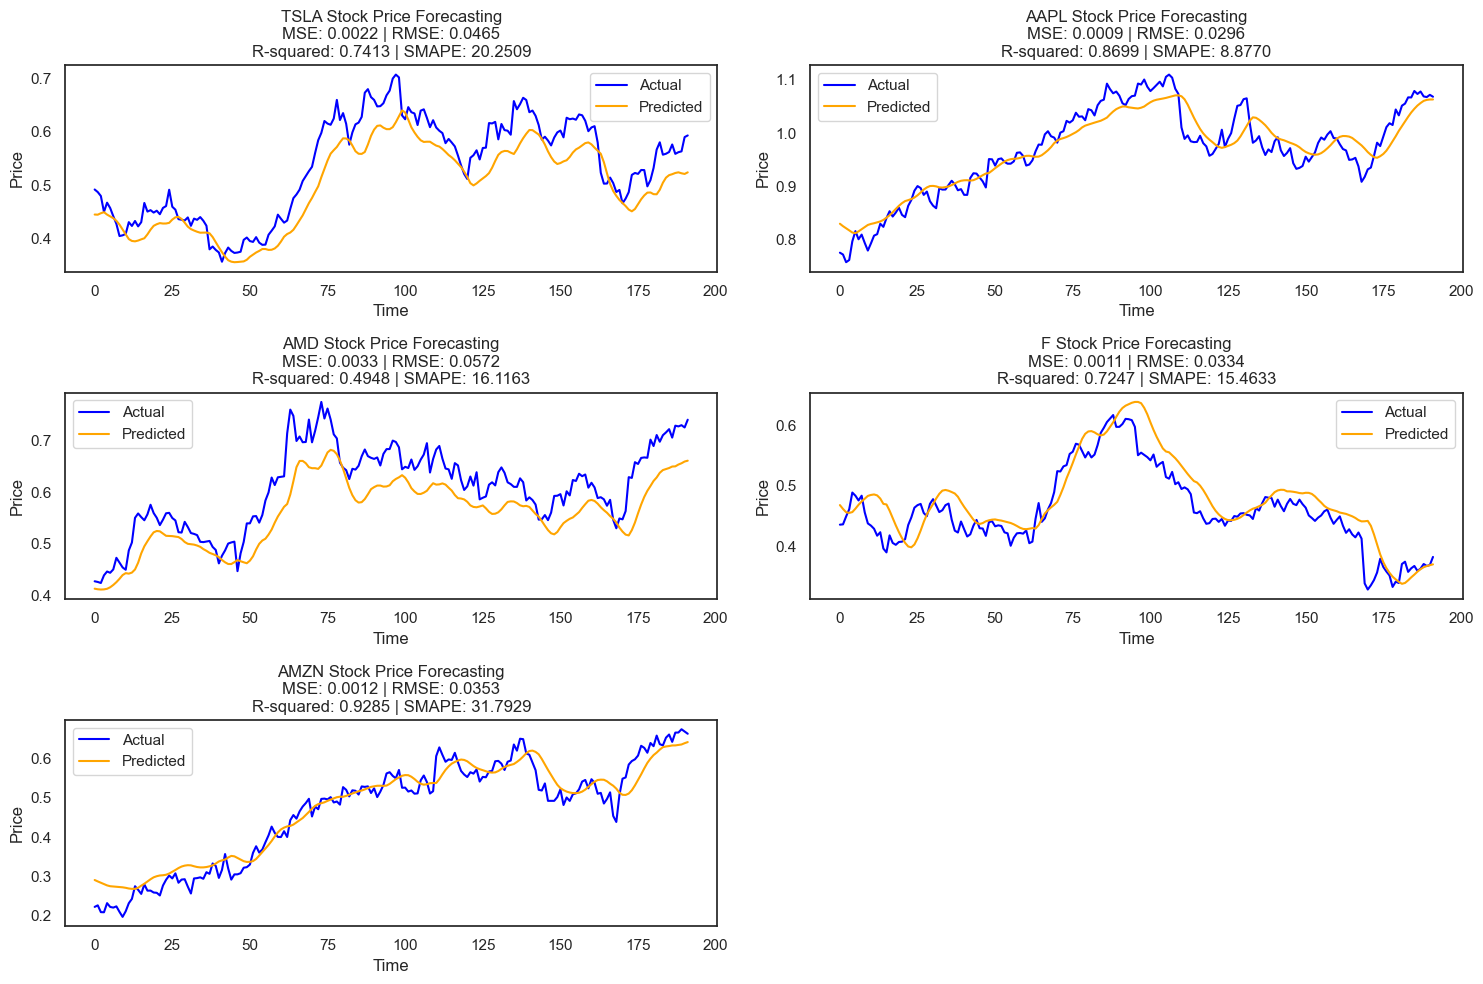

In [47]:
# 6. Plot results
plt.figure(figsize=(15, 10))
for i, (company, result) in enumerate(results.items(), 1):
    metrics = result['metrics']
    mse = metrics["MSE"]
    rmse = metrics["RMSE"]
    r2 = metrics["R-squared"]
    smape_value = metrics["SMAPE"]
    
    plt.subplot(3, 2, i)
    plt.plot(result['y_test'], label='Actual', color='blue')
    plt.plot(result['y_pred'], label='Predicted', color='orange')
    plt.title(f"{company} Stock Price Forecasting\n"
              f"MSE: {mse:.4f} | RMSE: {rmse:.4f}\n"
              f"R-squared: {r2:.4f} | SMAPE: {smape_value:.4f}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [48]:
evaluation_data[evaluation_data["model_name"] == "LSTM All Features"]

model_name company evaluation_type     result
40  LSTM All Features    TSLA             MSE   0.002165
41  LSTM All Features    TSLA            RMSE   0.046526
42  LSTM All Features    TSLA       R-squared   0.741348
43  LSTM All Features    TSLA           SMAPE  20.250872
44  LSTM All Features    AAPL             MSE   0.000878
45  LSTM All Features    AAPL            RMSE   0.029632
46  LSTM All Features    AAPL       R-squared   0.869917
47  LSTM All Features    AAPL           SMAPE   8.877031
48  LSTM All Features     AMD             MSE   0.003271
49  LSTM All Features     AMD            RMSE   0.057189
50  LSTM All Features     AMD       R-squared   0.494790
51  LSTM All Features     AMD           SMAPE  16.116336
52  LSTM All Features       F             MSE   0.001113
53  LSTM All Features       F            RMSE   0.033360
54  LSTM All Features       F       R-squared   0.724702
55  LSTM All Features       F           SMAPE  15.463295
56  LSTM All Features    AMZN             MSE   0.001248
57  LSTM All Features    AMZN            RMSE   0.035328
58  LSTM All Features    AMZN       R-squared   0.928515
59  LSTM All Features    AMZN           SMAPE  31.792941

In comparison to our baseline ARIMAX Model Overall the LSTM Model does perform better based on its evaluation metrics (MSE,RMSE,R-Squared) yet it has a overall lower SMAPE score which could affect our overall's model performance.

## LSTM with 'Close' Column Only

Our 2nd LSTM Model we decided to select only the select "Close" column to see how it would perform with only it's target variable

### Split Data

In [49]:
# Example: To access the DataFrame for 'AAPL':
aapl_df_c = company_dfs['AAPL']["Close"]
amd_df_c = company_dfs['AMD']["Close"]
amzn_df_c = company_dfs['AMZN']["Close"]
f_df_c = company_dfs['F']["Close"]
tsla_df_c = company_dfs['TSLA']["Close"]

# Splitting each company into train n test 
split_index = int(len(aapl_df_c) * 0.8)
aapl_train_c = aapl_df_c[:split_index]
aapl_test_c = aapl_df_c[split_index:]

amd_train_c = amd_df_c[:split_index]
amd_test_c = amd_df_c[split_index:]

amzn_train_c = amzn_df_c[:split_index]
amzn_test_c = amzn_df_c[split_index:]

f_train_c = f_df_c[:split_index]
f_test_c = f_df_c[split_index:]

tsla_train_c = tsla_df_c[:split_index]
tsla_test_c = tsla_df_c[split_index:]


### Scaling Data by Each Company

In [50]:
tukangScaling =MinMaxScaler()
aapl_train_c_scaled= tukangScaling.fit_transform(aapl_train_c.values.reshape(-1,1))
aapl_test_c_scaled= tukangScaling.transform(aapl_test_c.values.reshape(-1,1))

amd_train_c_scaled= tukangScaling.fit_transform(amd_train_c.values.reshape(-1,1))
amd_test_c_scaled= tukangScaling.transform(amd_test_c.values.reshape(-1,1))

amzn_train_c_scaled= tukangScaling.fit_transform(amzn_train_c.values.reshape(-1,1))
amzn_test_c_scaled= tukangScaling.transform(amzn_test_c.values.reshape(-1,1))

f_train_c_scaled= tukangScaling.fit_transform(f_train_c.values.reshape(-1,1))
f_test_c_scaled= tukangScaling.transform(f_test_c.values.reshape(-1,1))

tsla_train_c_scaled= tukangScaling.fit_transform(tsla_train_c.values.reshape(-1,1))
tsla_test_c_scaled= tukangScaling.transform(tsla_test_c.values.reshape(-1,1))

### LSTM Data Preparation

In [51]:
def prepare_lstm_data(scaled_array, sequence_length=60):
    """
    Prepares data for LSTM modeling for single-column data.
    
    Parameters:
        scaled_array (numpy.ndarray): The scaled array containing the target feature (e.g., 'Close').
        sequence_length (int): Number of time steps to include in each sample.
        
    Returns:
        X (numpy.ndarray): Feature array of shape (samples, sequence_length, 1).
        y (numpy.ndarray): Target array of shape (samples,).
    """
    X, y = [], []
    for i in range(sequence_length, len(scaled_array)):
        X.append(scaled_array[i-sequence_length:i])
        y.append(scaled_array[i])  # target is the next value after the sequence
    return np.array(X), np.array(y)

X_train_tsla_c, y_train_tsla_c = prepare_lstm_data(tsla_train_c_scaled)
X_test_tsla_c, y_test_tsla_c = prepare_lstm_data(tsla_test_c_scaled)

X_train_aapl_c, y_train_aapl_c = prepare_lstm_data(aapl_train_c_scaled)
X_test_aapl_c, y_test_aapl_c = prepare_lstm_data(aapl_test_c_scaled)

X_train_amd_c, y_train_amd_c = prepare_lstm_data(amd_train_c_scaled)
X_test_amd_c, y_test_amd_c = prepare_lstm_data(amd_test_c_scaled)

X_train_f_c, y_train_f_c = prepare_lstm_data(f_train_c_scaled)
X_test_f_c, y_test_f_c = prepare_lstm_data(f_test_c_scaled)

X_train_amzn_c, y_train_amzn_c = prepare_lstm_data(amzn_train_c_scaled)
X_test_amzn_c, y_test_amzn_c = prepare_lstm_data(amzn_test_c_scaled)

In [52]:
def insert_lstm_results_2(y_true, y_pred, company_name, model_name="LSTM Close Column Only"):
    """
    Calculate and store evaluation metrics for an LSTM model in the global evaluation DataFrame.
    Parameters:
    - y_true: Actual values
    - y_pred: Predicted values
    - company_name: Name of the company (str)
    - model_name: Name of the model (str, default: "LSTM")
    """
    global evaluation_data
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    smape_value = smape(y_true, y_pred)
    
    # Append metrics to the evaluation DataFrame
    metrics_dict = {
        "MSE": mse,
        "RMSE": rmse,
        "R-squared": r2,
        "SMAPE": smape_value
    }
    
    for metric_name, metric_value in metrics_dict.items():
        evaluation_data = pd.concat([
            evaluation_data,
            pd.DataFrame({
                "model_name": [model_name],
                "company": [company_name],
                "evaluation_type": [metric_name],
                "result": [metric_value]
            })
        ], ignore_index=True)
    
    # Return metrics for display or plotting
    return metrics_dict

### Train Data

In [53]:
# 3. Define the LSTM training function
def train_lstm_model_2(X_train, y_train, X_test, y_test, input_shape, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_split=0.2, verbose=1)

    y_pred = model.predict(X_test)
    return model, history, y_pred

# Company datasets
companies_c = {
    'TSLA': (X_train_tsla_c, y_train_tsla_c, X_test_tsla_c, y_test_tsla_c),
    'AAPL': (X_train_aapl_c, y_train_aapl_c, X_test_aapl_c, y_test_aapl_c),
    'AMD': (X_train_amd_c, y_train_amd_c, X_test_amd_c, y_test_amd_c),
    'F': (X_train_f_c, y_train_f_c, X_test_f_c, y_test_f_c),
    'AMZN': (X_train_amzn_c, y_train_amzn_c, X_test_amzn_c, y_test_amzn_c)
}

# Store results for all companies
results_c = {}

# Train and predict for each company
for company, (X_train, y_train, X_test, y_test) in companies_c.items():
    print(f"Training model for {company}...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Train the model
    model, history, y_pred = train_lstm_model_2(X_train, y_train, X_test, y_test, input_shape)

    # Insert LSTM results and metrics into the global evaluation DataFrame
    metrics = insert_lstm_results_2(y_test, y_pred, company_name=company, model_name="LSTM Close Column Only")

    # Store the model, history, predictions, and metrics in the results_c dictionary
    results_c[company] = {
        'model': model,
        'history': history,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': metrics  # Metrics are already returned from insert_lstm_results_2
    }


Training model for TSLA...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0706 - val_loss: 0.0071
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031 - val_loss: 0.0064
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━

### Plotting the results

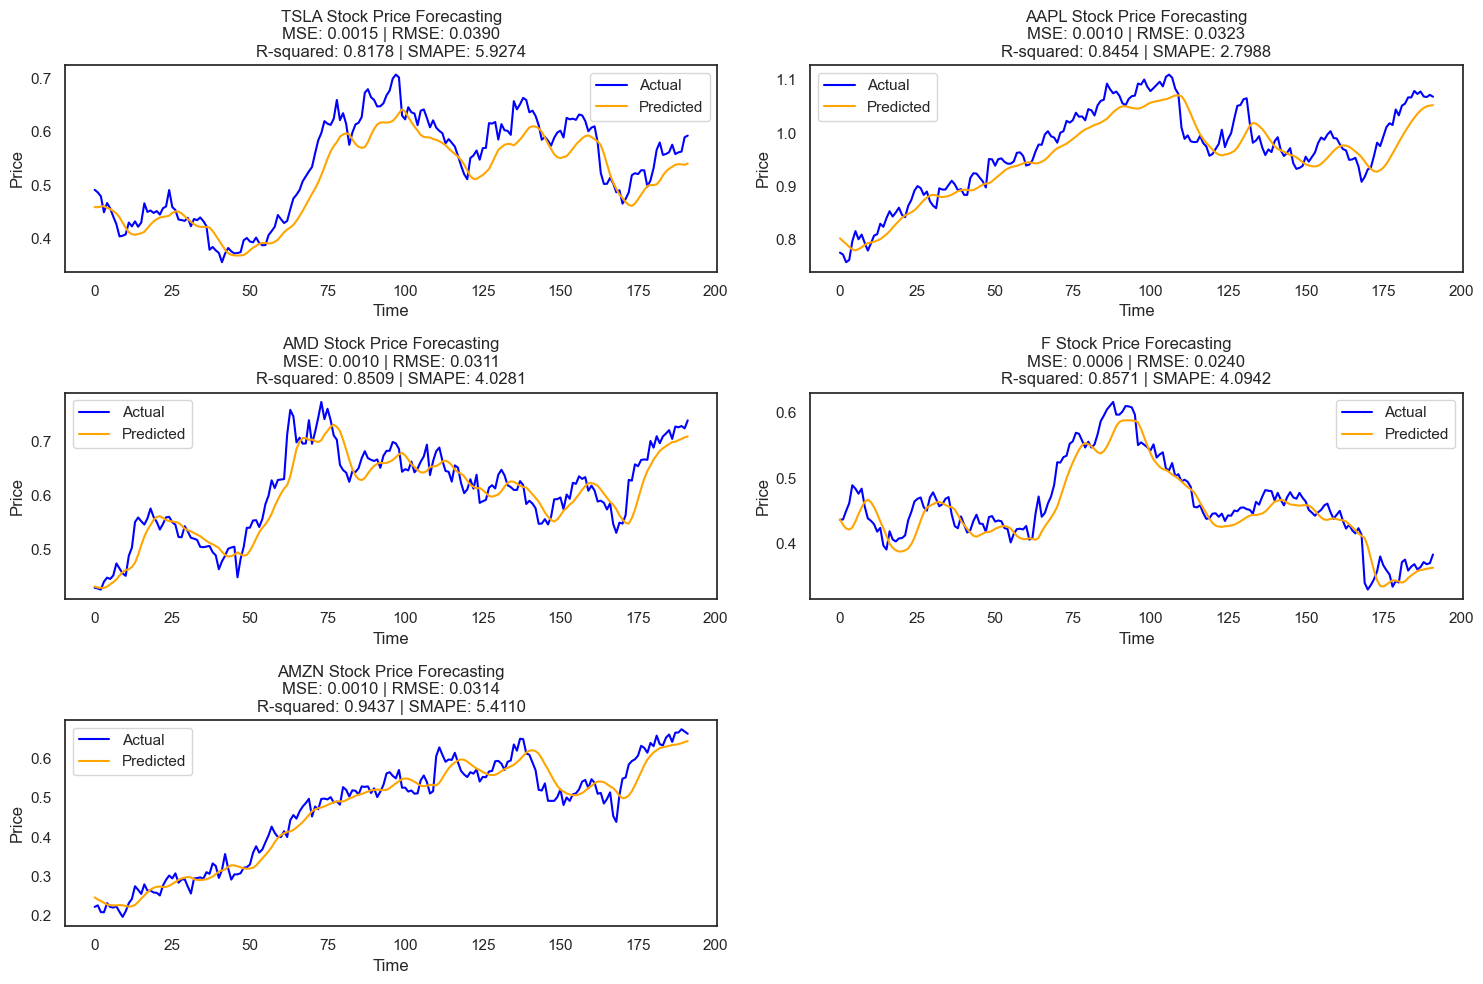

In [54]:
# 6. Plot results
plt.figure(figsize=(15, 10))
for i, (company, result) in enumerate(results_c.items(), 1):
    metrics = result['metrics']
    mse = metrics["MSE"]
    rmse = metrics["RMSE"]
    r2 = metrics["R-squared"]
    smape_value = metrics["SMAPE"]
    
    plt.subplot(3, 2, i)
    plt.plot(result['y_test'], label='Actual', color='blue')
    plt.plot(result['y_pred'], label='Predicted', color='orange')
    plt.title(f"{company} Stock Price Forecasting\n"
              f"MSE: {mse:.4f} | RMSE: {rmse:.4f}\n"
              f"R-squared: {r2:.4f} | SMAPE: {smape_value:.4f}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [55]:
evaluation_data[evaluation_data["model_name"] == "LSTM Close Column Only"]

model_name company evaluation_type    result
60  LSTM Close Column Only    TSLA             MSE  0.001524
61  LSTM Close Column Only    TSLA            RMSE  0.039044
62  LSTM Close Column Only    TSLA       R-squared  0.817849
63  LSTM Close Column Only    TSLA           SMAPE  5.927363
64  LSTM Close Column Only    AAPL             MSE  0.001043
65  LSTM Close Column Only    AAPL            RMSE  0.032299
66  LSTM Close Column Only    AAPL       R-squared  0.845443
67  LSTM Close Column Only    AAPL           SMAPE  2.798843
68  LSTM Close Column Only     AMD             MSE  0.000965
69  LSTM Close Column Only     AMD            RMSE  0.031071
70  LSTM Close Column Only     AMD       R-squared  0.850872
71  LSTM Close Column Only     AMD           SMAPE  4.028096
72  LSTM Close Column Only       F             MSE  0.000578
73  LSTM Close Column Only       F            RMSE  0.024033
74  LSTM Close Column Only       F       R-squared  0.857114
75  LSTM Close Column Only       F           SMAPE  4.094219
76  LSTM Close Column Only    AMZN             MSE  0.000983
77  LSTM Close Column Only    AMZN            RMSE  0.031353
78  LSTM Close Column Only    AMZN       R-squared  0.943696
79  LSTM Close Column Only    AMZN           SMAPE  5.411022

In [57]:
evaluation_data[evaluation_data["model_name"] == "LSTM All Features"]


model_name company evaluation_type     result
40  LSTM All Features    TSLA             MSE   0.002165
41  LSTM All Features    TSLA            RMSE   0.046526
42  LSTM All Features    TSLA       R-squared   0.741348
43  LSTM All Features    TSLA           SMAPE  20.250872
44  LSTM All Features    AAPL             MSE   0.000878
45  LSTM All Features    AAPL            RMSE   0.029632
46  LSTM All Features    AAPL       R-squared   0.869917
47  LSTM All Features    AAPL           SMAPE   8.877031
48  LSTM All Features     AMD             MSE   0.003271
49  LSTM All Features     AMD            RMSE   0.057189
50  LSTM All Features     AMD       R-squared   0.494790
51  LSTM All Features     AMD           SMAPE  16.116336
52  LSTM All Features       F             MSE   0.001113
53  LSTM All Features       F            RMSE   0.033360
54  LSTM All Features       F       R-squared   0.724702
55  LSTM All Features       F           SMAPE  15.463295
56  LSTM All Features    AMZN             MSE   0.001248
57  LSTM All Features    AMZN            RMSE   0.035328
58  LSTM All Features    AMZN       R-squared   0.928515
59  LSTM All Features    AMZN           SMAPE  31.792941

If we compare the two LSTM models results we can see an improvement in a majority of the evaluation metrics above mainly the SMAPE score which dropped drastically in comparison to using all features instead of just the close feature.

In [56]:
# evaluation_data.to_csv('output_final.csv', index=False)  # index=False avoids adding an extra index column

# Final Evaluation

The goal of project is to create a forecasting model to evaluate and see if it is fit for further use, it is evaluated based on MSE,RMSE,SMAPE, and R-Squared.
- ARIMAX All Features -> A greate R-Squared value overall but performed significantly worse when given fluctuative/volitile data such as TSLA/AMZN.
- ARIMAX Close Only -> Had the lowest overall performance in comparison to all our models
- LSTM All Features -> Had a great performance except in the SMAPE metric which made us believe it's performance is not what it seemed to be.
- LSTM Close Only -> Had the best overall performance on every evaluation metric

It should be noted that these performances could (probably is) linked to which actual company data stock prices as they performed differently in the real world such as TSLA AMD AMZN has been booming lately leading to a much more fast yet volitile growth causing our forecasting model to struggle yet with slower companies such as Ford ending up being easier to forecast

The key takeaway we can provide is that our proposed model LSTM using the only the "Close" feature performed the best overall by every performance metric. with overall a pretty low % of errors predicitng stock values, while this model is not perfect and there is much room for improvement it can't be taken lightly of what this model is capable of doing.